<a href="https://colab.research.google.com/github/karaposu/Brain_typing/blob/master/Brain_Typing_Reproducing_with_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#REPRODUCING THE PAPER : BRAIN TYPING 

**FULL PAPER NAME** : *Converting Your Thoughts to Texts: Enabling Brain Typing via Deep Feature Learning of EEG Signals* , Xiang Zhang 


**Summary**  : Classifying motor imagery EEG data using parallel feature extraction (CNN + RNN) and XGBOOST algorithm. Result :  %95 Accuracy (%99.57 in reproduction 😎)


**Reproduced by** : ENES ESVET KUZUCU 
eneskuzucu@hotmail.com , https://www.linkedin.com/in/enes-kuzucu-45807bb2/


**Original Paper Link** : 

https://ieeexplore.ieee.org/document/8444575


 



**Abstract :**
*In this paper, we propose a novel deep
neural network based learning framework that affords perceptive
insights into the relationship between the MI-EEG data and
brain activities. We design a joint convolutional recurrent neural network that simultaneously learns robust high-level feature presentations through low-dimensional dense embeddings from raw MI-EEG (Movement Imagery EEG) signals. We also employ an Autoencoder layer to eliminate various artifacts such as background activities. The results show that our approach
outperforms a series of baselines and the competitive state-of-theart methods, yielding a classification accuracy of 95.53%.*


**Reproduction Note :** 
Paper uses the correlation of imagery movements and their effects on brain signals to interract with a brain typing interface. And to explore this correspondence they are utilizing CNN and RNN based machine learning models as features extracters. And then they are using the combined extracted features to classify the data using Autoencoders and XGBOOST. Original paper uses tensorflow 1.4 which is very outdated. So I recreated all process with PyTorch with neccessary differences. And without utilizing Autoencoders I managed to obtain %99 accuracy.



In [1]:
%%capture
import cv2
from google.colab.patches import cv2_imshow


! wget https://raw.githubusercontent.com/karaposu/Brain_typing/master/a.png
! wget https://raw.githubusercontent.com/karaposu/Brain_typing/master/b.png

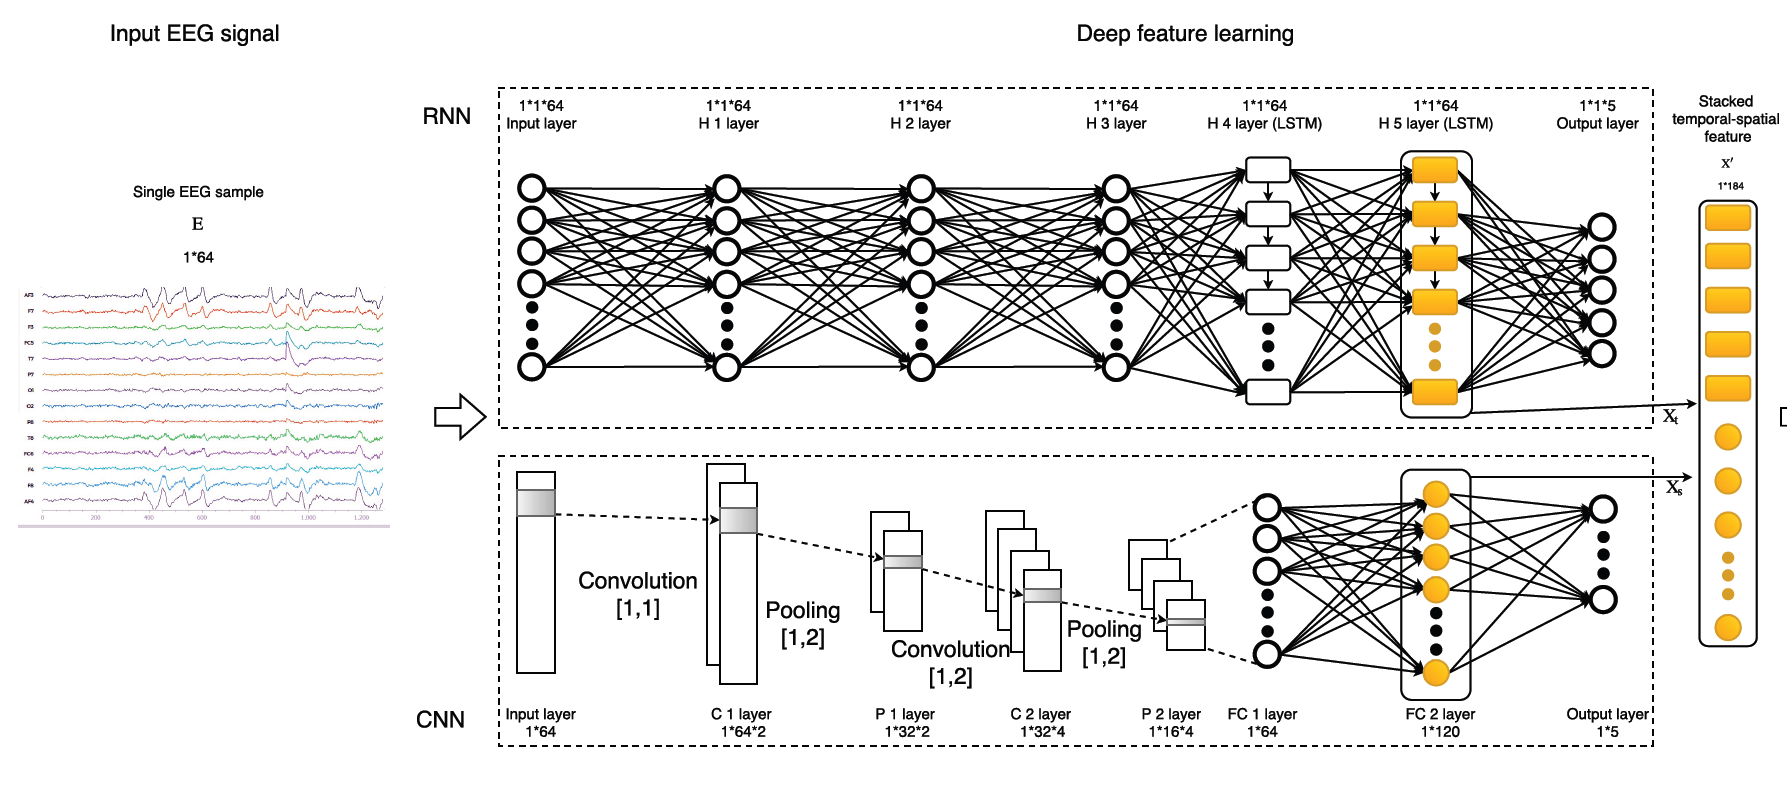

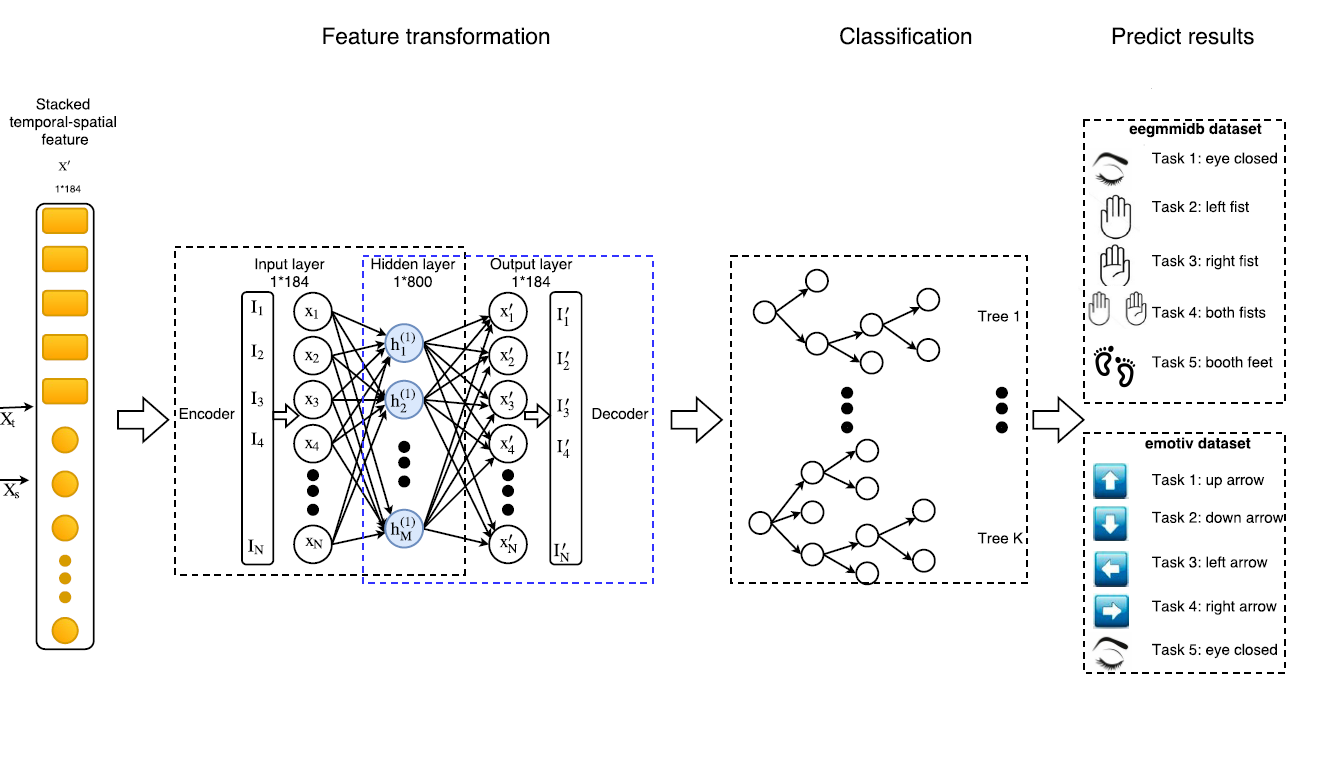

In [2]:
image = cv2.imread('a.png')
image2 = cv2.imread('b.png')
cv2_imshow( image)
cv2_imshow( image2)

#IMPORTS


In [3]:
import matplotlib.pyplot as plt
import matplotlib.image as img
import torchvision.transforms as transforms
from sklearn import model_selection
import numpy as np
import scipy.io as sc
import numpy as np
import random
import time
from sklearn import preprocessing
from numpy import sqrt
import scipy as sp
import math
import torch
import torchvision
print(torch.__version__)
print(torchvision.__version__)
import torch.nn as nn
from typing import Type, Any, Callable, Union, List, Optional, cast
from torch import Tensor
from collections import OrderedDict 
from torchvision import models 
import os
import zipfile
import sys
import imutils
import cv2
from PIL import Image
import pathlib
from skimage import io
import numpy as np
from sklearn.preprocessing import MinMaxScaler

import torch
from torch import nn
from torch.nn import functional as F
from torch.autograd import Variable

!pip install torchsummary
from torchsummary import summary
# summary(your_model, input_size=(channels, H, W))
    

1.10.0+cu111
0.11.1+cu111


#HELPER FUNCTIONS

In [4]:

def xray(x ):
    # !pip install -U varname
    # from varname import varname, nameof
    # name= nameof(x)

    import torch
    import numpy as np


  #   if not a:
  # print("List is empty")
    if isinstance(x, list):
      if isinstance(x[0], torch.Tensor):
        print("List of Tensors,", " Len:", len(x), ", e[0] shape:" , x[0].shape  )
      else:
        print("List,", " Len:", len(x), ", Type-e[0]:" , type(x[0])  )
    elif isinstance(x, (np.ndarray, np.generic) ):
        print("np.array,", " Shape:", x.shape )    
    elif isinstance(x, dict):
      e=list(x.values())[0]
      k=list(x.keys())[0]
      print("Dict,", "Len:", len(x), " Keys (Tensor): ", k.shape, " Values (Tensor): " , e.shape  )
    elif isinstance(x, tuple):
       if isinstance(x[0], torch.Tensor):
          print("Tuple of Tensors,", " Len:", len(x), ", e[0] shape:" , x[0].shape  )
       else:
          print("Tuple,", " Len:", len(x), ", Type-v[0]:" , type(x[0])  )


    elif isinstance(x, torch.Tensor):
        print("Tensor,", " Shape:", x.shape  )
    

    


def row_trim(x ,lw, bg):
    marked_idxs= []
    shape= x.shape
    # print(shape)
    for i in range(shape[0] ):
      for e in x[i]:
        if e> bg:
          marked_idxs.append(i)
        elif e< lw:
          marked_idxs.append(i)
    z = np.delete(x, marked_idxs, axis=0)
    return z


    
def convert_tensor_to_list_of_tensors(x):
  list_of_tensors=[]

  for i in range(x.shape[0]):
    list_of_tensors .append(x[i,:])

  return list_of_tensors


def convert_list_of_tensors_to_tensor(x):
  
  x = torch.stack(x)


  return x


# print_multiple_variables
def pmv(M): 
  length=len(M)
  for i in range(length):
    print(M[i].shape)

  # return None



class Lin_View(nn.Module):
	def __init__(self):
		super(Lin_View, self).__init__()
	def forward(self, x):
		return x.view(x.size()[0], -1)

# this function is used to transfer one column label to one hot label
def one_hot(y):
    # Function to encode output labels from number indexes
    # e.g.: [[5], [0], [3]] --> [[0, 0, 0, 0, 0, 1], [1, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0]]
    y= y.reshape(len(y))
    n_values = np.max(y) + 1
    return np.eye(n_values)[np.array(y, dtype=np.int32)]

def printt():
   print(" ")
   print(" ")
   print(" ")




def check_shape_and_type_of_loaderdata(loader):
  counter=0
  sample=0
  sample_target=0
  for e , i in loader:
    if counter==0:
      sample=e
      sample_target=i
      counter+counter+1
    break


  print("________________________________________")
 
  print("For Loader data:" )
  print("Shape data: ",  e.shape, "Dtype data: ",e.dtype )
  print("Shape label: ",sample_target.shape, "      Dtype label: ",sample_target.dtype )
  print("________________________________________")


  return e,sample_target
 




def plot_signal(x, y, size_figure, title,type):
  
  if type==0: 

    
    fig = plt.figure(figsize=size_figure )
    fig.suptitle(title, fontweight ="bold") 
    fig.set_dpi=(500) 
    plt.plot(x,y)
    plt.grid(axis='both', alpha=.3)
    plt.show()

  else:

    # plt.scatter(x, label)

    fig = plt.figure(figsize=size_figure )
    fig.suptitle(title, fontweight ="bold") 
    fig.set_dpi=(500) 
    plt.scatter(x,y)
    plt.grid(axis='both', alpha=.3)
    plt.show()


def plot_signal_with_figtext(x, y, size_figure, title,type, figtext):
  # plt.figtext(0, 4, "T = 4K")
  if type==0: 

    
    fig = plt.figure(figsize=size_figure )
    fig.suptitle(title, fontweight ="bold") 
    fig.set_dpi=(500) 
    plt.figtext(figtext[0], figtext[1], figtext[2])
    plt.grid(axis='both', alpha=.3)
    plt.plot(x,y)
    
    plt.show()

  else:

    # plt.scatter(x, label)

    fig = plt.figure(figsize=size_figure )
    fig.suptitle(title, fontweight ="bold") 
    fig.set_dpi=(500) 
    plt.figtext(figtext[0], figtext[1], figtext[2])
    plt.scatter(x,y)
    plt.grid(axis='both', alpha=.3)
    plt.show()



def trim_max_values_in_np_array(feature_all):

  idx=np.argwhere(feature_all < -300)
  # a = np.array([1,2,3,4,5,6,7,8,9,10])
  # idx = np.stack([[2, 3], [7, 8]])
  feature_all[idx] = -300
  # np.delete(a, idx[:, 1:])
  

  

#DATA LOADING & PREPROCESSING

###GET-DATA

Copying original data and my trained models from github.

In [5]:
%%capture
!git clone https://github.com/karaposu/Brain_typing.git

! cp  /content/Brain_typing/emotiv_7sub_5class.mat  . 
! cp  /content/Brain_typing/S1_nolabel6.mat  . 

! cp  /content/Brain_typing/model_CNN_1000E_075_ACC.pt  . 
! cp  /content/Brain_typing/model_RNN_869e_ACC_098.rar  . 
! cp  /content/Brain_typing/RNN2_595e_097_acc.pt  . 


!pip install patool
import patoolib
patoolib.extract_archive("model_RNN_869e_ACC_098.rar", outdir="/content/")



###LOAD-DATA

In [6]:
feature = sc.loadmat("S1_nolabel6.mat")
all = feature['S1_nolabel6']
all_orig= all.copy()  
#  all_orig will be used for plotting origninal signals
print ("Shape of Original Data : ", all_orig.shape)

# And also we will clean the high noisy part of the data immidiately.

print ("Max value in Original data : ",np.amax(all))
print ("Min value in Original data : ",np.amin(all))
print (" ")


all= row_trim(all ,-250, 250)
print ("Shape of cleaned Data : ", all.shape)
print ("Max value in clean data : ",np.amax(all))
print ("Min value in clean data : ",np.amin(all))


#  After cleaning  we will separate the data as features and lables 

# We will get 28000 samples and discard the rest 
all=all[0:28000]
print ("Last shape before separation : ", all.shape)

# This step is essential. We need to shuffle data because otherwise Neural Networks...
# will not be able to learn different features.
# And we need to shuffle before seperating the data into labels and features...
# so after shuffle  features and corresponding labels will stick together.
np.random.shuffle(all)   # mix eeg_all

# We have 65 columns for each row.First 64 column is for EEG channels and Last column is for labels.

feature_all =all[:,0:64]
label=all[:,64:65]

# Also we will seperate the original data for plotting signals and their labels
all_orig= all_orig[0:28000]
feature_all_orig= all_orig[:,0:64]
label_orig= all_orig[:,64:65]





Shape of Original Data :  (29738, 65)
Max value in Original data :  577
Min value in Original data :  -655
 
Shape of cleaned Data :  (28897, 65)
Max value in clean data :  250
Min value in clean data :  -250
Last shape before separation :  (28000, 65)


##INSPECT-DATA (SHAPES AND DTYPES)



<pre><code>╔══════════════════════════╦═══════════════════════════════╦════════════════════╦═════════════════════════╗
║        Data type         ║             dtype             ║     CPU tensor     ║       GPU tensor        ║
╠══════════════════════════╬═══════════════════════════════╬════════════════════╬═════════════════════════╣
║ 32-bit floating point    ║ torch.float32 or torch.float  ║ torch.FloatTensor  ║ torch.cuda.FloatTensor  ║
║ 64-bit floating point    ║ torch.float64 or torch.double ║ torch.DoubleTensor ║ torch.cuda.DoubleTensor ║
║ 16-bit floating point    ║ torch.float16 or torch.half   ║ torch.HalfTensor   ║ torch.cuda.HalfTensor   ║
║ 8-bit integer (unsigned) ║ torch.uint8                   ║ torch.ByteTensor   ║ torch.cuda.ByteTensor   ║
║ 8-bit integer (signed)   ║ torch.int8                    ║ torch.CharTensor   ║ torch.cuda.CharTensor   ║
║ 16-bit integer (signed)  ║ torch.int16 or torch.short    ║ torch.ShortTensor  ║ torch.cuda.ShortTensor  ║
║ 32-bit integer (signed)  ║ torch.int32 or torch.int      ║ torch.IntTensor    ║ torch.cuda.IntTensor    ║
║ 64-bit integer (signed)  ║ torch.int64 or torch.long     ║ torch.LongTensor   ║ torch.cuda.LongTensor   ║
║ Boolean                  ║ torch.bool                    ║ torch.BoolTensor   ║ torch.cuda.BoolTensor   ║
╚══════════════════════════╩═══════════════════════════════╩════════════════════╩═════════════════════════╝

In [7]:
print ("Dtpye feature_all : ",feature_all.dtype)
print ("Dtpye label: ",label.dtype)
print ("Shape feature_all: ",feature_all.shape)
print ("Shape label: ",label.shape)
print(" ")
example_data= feature_all[0]
example_label= label[0]
print ("sample data : : ",example_data)
print ("sample label : : ",example_label)



Dtpye feature_all :  int16
Dtpye label:  int16
Shape feature_all:  (28000, 64)
Shape label:  (28000, 1)
 
sample data : :  [-115  -89  -81  -82  -64  -57  -37 -111  -67  -65  -70  -46  -50  -30
  -88  -53  -55  -43  -40  -42  -41 -122  -86  -84 -128 -121  -70  -72
  -39 -118  -72  -69  -78  -68  -65  -67  -63    2 -121  -30 -114  -16
  -90   37  -97   -1  -61  -58  -37  -27  -27  -19  -22  -12    6  -37
  -49  -17   -3    3  -34  -18  -32    3]
sample label : :  [5]


##ALTER-DATA
In data labels are 1 , 2 , 3 , 4, 5

Since we want to use one hot encoding we are substracting 1 from all labels to convert them to  0, 1, 2, 3, 4

Also we are changing data type of features to  np.float32
and datatype of labels to int64

In [8]:
label=label-1

# no_fea=64
# n_classes=5


print ("Dtpye feature_all : ",feature_all.dtype)
feature_all= np.float32(feature_all)
print ("Dtpye-new feature_all: ",feature_all.dtype)
print ("Dtpye label: ",label.dtype)
label= np.int64(label)
print ("Dtpye-new label: ",label.dtype)
print (" ")


example_data= feature_all[0]
print ("sample data without normalization : : ",example_data)
print (" ")


# feature_all=preprocessing.scale(feature_all)

# scaler = MinMaxScaler()
# feature_all = scaler.fit_transform(feature_all)

# example_data= feature_all[0]
# print ("sample data after normalization : : ",example_data)
# print (" ")



Dtpye feature_all :  int16
Dtpye-new feature_all:  float32
Dtpye label:  int16
Dtpye-new label:  int64
 
sample data without normalization : :  [-115.  -89.  -81.  -82.  -64.  -57.  -37. -111.  -67.  -65.  -70.  -46.
  -50.  -30.  -88.  -53.  -55.  -43.  -40.  -42.  -41. -122.  -86.  -84.
 -128. -121.  -70.  -72.  -39. -118.  -72.  -69.  -78.  -68.  -65.  -67.
  -63.    2. -121.  -30. -114.  -16.  -90.   37.  -97.   -1.  -61.  -58.
  -37.  -27.  -27.  -19.  -22.  -12.    6.  -37.  -49.  -17.   -3.    3.
  -34.  -18.  -32.    3.]
 


###ALTER LABELS

Different models may require different label format. Here I am reshaping labels in one hot encoded (OHE) format and also adding some dimensions. So i can choose any kind of format later.

In [9]:


print ("Shape label: ",label.shape)
label=label.squeeze()
print ("Shape-new label: ",label.shape)

label_all_no_OHE = label
print ("Shape label_all_no_OHE:          ",label_all_no_OHE.shape)

label_all_OHE=one_hot(label)
print ("Shape label_all_OHE:             ",label_all_OHE.shape)
label_all_OHE_extra_dim = np.expand_dims(label_all_OHE, axis=1)

print ("Shape label_all_OHE_extra_dim :  ",label_all_OHE_extra_dim.shape)

label_training_no_ohe =label_all_no_OHE[0:21000]
label_testing_no_ohe =label_all_no_OHE[21000:28000]

label_training_OHE_extra_dim =label_all_OHE_extra_dim[0:21000]
label_testing_OHE_extra_dim =label_all_OHE_extra_dim[21000:28000]

label_training_OHE =label_all_OHE[0:21000]
label_testing_OHE =label_all_OHE[21000:28000]


print("Shape label_training_no_ohe          ",label_training_no_ohe.shape)
print("Shape label_testing_no_ohe           ",label_testing_no_ohe.shape)
print("Shape label_training_OHE_extra_dim   ",label_training_OHE_extra_dim.shape)
print("Shape label_testing_OHE_extra_dim    ",label_testing_OHE_extra_dim.shape)
print("Shape label_training_OHE             ",label_training_OHE.shape)
print("Shape label_testing_OHE              ",label_testing_OHE.shape)




Shape label:  (28000, 1)
Shape-new label:  (28000,)
Shape label_all_no_OHE:           (28000,)
Shape label_all_OHE:              (28000, 5)
Shape label_all_OHE_extra_dim :   (28000, 1, 5)
Shape label_training_no_ohe           (21000,)
Shape label_testing_no_ohe            (7000,)
Shape label_training_OHE_extra_dim    (21000, 1, 5)
Shape label_testing_OHE_extra_dim     (7000, 1, 5)
Shape label_training_OHE              (21000, 5)
Shape label_testing_OHE               (7000, 5)


###ALTER FEATURES

Altering feature dimensions and shape

In [10]:


print ("Shape feature_all: ",feature_all.shape)
feature_all = np.expand_dims(feature_all, axis=1)
print ("Shape-new feature_all :  ",feature_all.shape)


feature_training =feature_all[0:21000]
feature_testing =feature_all[21000:28000]

print("Shape feature_training:  ",feature_training.shape)
print("Shape feature_testing:   ",feature_testing.shape)


feature_training_with_extra_dimension = np.expand_dims(feature_training, axis=1)
feature_testing_with_extra_dimension = np.expand_dims(feature_testing, axis=1)


print("Shape feature_training_with_extra_dimension:  ",feature_training_with_extra_dimension.shape)
print("Shape feature_testing_with_extra_dimension:  ",feature_testing_with_extra_dimension.shape)



Shape feature_all:  (28000, 64)
Shape-new feature_all :   (28000, 1, 64)
Shape feature_training:   (21000, 1, 64)
Shape feature_testing:    (7000, 1, 64)
Shape feature_training_with_extra_dimension:   (21000, 1, 1, 64)
Shape feature_testing_with_extra_dimension:   (7000, 1, 1, 64)


#MODELS

I tried bunch of different models. Main models used in final process are "CNN2D V2" and "RNN2" models

Also I implemented 7 different Autoencoder models including Variational Autoencoder. However so far they only decrease the final accuracy. 

You can see Feature Extracter Model. Which is basically takes a model and add hooks of that models intended layers and outputs hooked version of that model. This Feature Extracter is used on CNN2D V2 and RNN2 to extract features as original paper used.

##CNN MODEL

In [11]:
import torch
from torch import nn
from torch.nn import functional as F


class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.conv_1 = nn.Conv1d(1, 2, kernel_size=(1))
        self.pool_1 = nn.MaxPool1d(kernel_size=(2))
        self.conv_2 = nn.Conv1d(2, 4, kernel_size=(1))
        self.pool_2 = nn.MaxPool1d(kernel_size=(2))

        # mat1 and mat2 shapes cannot be multiplied (28000x16 and 256x64)
        self.fc1 = nn.Linear(64, 120)
        self.fc2 = nn.Linear(120, 5)

        # nn.BatchNorm1d

        global counter2

        counter2 = 0

    def forward(self, x, targets):
        global counter2


        if counter2 == 0:
            print(" Size Input for Model  :", x.size())
        bs, ch, width = x.size()
        
        

        x = F.relu(self.conv_1(x))

        if counter2 == 0:
            print(" Size After Conv1 :", x.size())

        x = self.pool_1(x)
        if counter2 == 0:
            print(" Size After pool1:", x.size())

        x = F.relu(self.conv_2(x))
        if counter2 == 0:
            print(" Size After Conv2:", x.size())

        x = self.pool_2(x)

        if counter2 == 0:
            print(" Size After pool2:", x.size())


        x=x.view(x.size()[0], -1)


        if counter2 == 0:
            print(" Size After view:", x.size())


        # x = F.relu(self.fc1(x))
        # x = F.sigmoid(self.fc1(x))


        x=self.fc1(x)
        # x = F.relu(x)
        

        if counter2 == 0:
            print(" Size After fc2:", x.size())

        x = self.fc2(x)

        if counter2 == 0:
            print(" Size After Output Layer:", x.size())
            counter2= counter2+1

         

        
       
        if targets is not None:
              

              # print(" -----------------------Debug Loss CNN ----------------")
              # print(" Shape x", x.size())
              # print(" Dtype x", x.dtype)
              # print(" Shape targets", targets.size())
              # print(" Dtype targets", targets.dtype)

              crit = nn.CrossEntropyLoss()
              loss=crit(x, targets)

              # loss = crit(x, torch.max(targets, 1)[1])
              # print("loss:", output)

              loss.backward()

              return x, loss

        return x, None

##CNN2D v2

In [12]:
import torch
from torch import nn
from torch.nn import functional as F

# BN layers normalize the activation of a convolution layer during the training, 
# which accelerates the training and has some regularization characteristics that help prevent overfitting. 


class CNN2v2(nn.Module):
    def __init__(self):
        super(CNN2v2, self).__init__()

        self.conv_1 = nn.Conv2d(1, 20, kernel_size=(1,1) , stride =(1,1) )
        self.pool_1 = nn.MaxPool2d(kernel_size=(1,2))
        
        self.pool_2 = nn.MaxPool2d(kernel_size=(1,2))
        self.dropout = nn.Dropout(0.25)
        
        self.fc1 = nn.Linear(640, 120)
        self.fc2 = nn.Linear(120, 5)

        

        global counter2

        counter2 = 0

    def forward(self, x, targets):
        global counter2


        if counter2 == 0:
            print(" Size Input for Model  :", x.size())
        bs= x.size()[0]
        
        

        x = F.relu(self.conv_1(x))



        if counter2 == 0:
            print(" Size After Conv1 :", x.size())

        x = self.pool_1(x)
        if counter2 == 0:
            print(" Size After pool1:", x.size())
            print(" x.size()[0]:", x.size()[0])

        x=x.contiguous()

        x=x.view(x.size()[0], -1)


        if counter2 == 0:
            print(" Size After view:", x.size())


        x=self.fc1(x) 

        if counter2 == 0:
            print(" Size After fc1:", x.size())  


        x = torch.sigmoid(x)

        x =self.dropout(x)
       
        

        x=self.fc2(x)  

        if counter2 == 0:
            print(" Size After fc2:", x.size()) 
            print("  ") 
            counter2= counter2+1


       
        if targets is not None:
              

              # print(" -----------------------Debug Loss CNN ----------------")
              # print(" Shape x", x.size())
              # print(" Dtype x", x.dtype)
              # print(" Shape targets", targets.size())
              # print(" Dtype targets", targets.dtype)

              crit = nn.CrossEntropyLoss()
              loss=crit(x, targets)

              # loss = crit(x, torch.max(targets, 1)[1])
              # print("loss:", output)

              loss.backward()

              return x, loss

        return x, None


    def train_with_loader(self, EPOCH, train_loader ,test_loader, eval_period,optimizer):


      print(" ")
      print("______________________   TRAINING ______________________")
      print(" ")


      


      for epoch in range(EPOCH):
          self.epoch=epoch

          train_loss = train_function(self, train_loader, optimizer)
          all_predictions= []

          if (epoch + 1) % eval_period == 0:


            outputs, test_loss = eval_function(self, test_loader, optimizer)

            for e in outputs:
                  batch_predictions = self.decode_batch_outputs(e)
                  all_predictions.extend(batch_predictions)

            a=accuracy_score(label_testing_no_ohe,  all_predictions)
            print("Epoch  :",epoch+1 , ", Loss :", train_loss, ", Acc:", a)
            self.epoch=epoch
            self.train_loss=train_loss
            

    def save_trained_model(self, name, optimizer  ):

            EPOCH = self.epoch
            PATH = name
            LOSS = self.train_loss

            torch.save({'epoch': EPOCH,
                        'model_state_dict': self.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'loss': LOSS, }, PATH)
            
    
    def decode_batch_outputs(batch_outputs):
        import torch

        # print(" Shape batch_outputs",batch_outputs.shape)
        # Shape batch_outputs torch.Size([50, 5])
        predictions=[]
        bs , _ = batch_outputs.shape
        
        k=torch.softmax(batch_outputs, 1)

      
        for j in range(bs):
            temp=k[j,:]
            # print("tem:", temp)
            prediction= decode_model_output(temp)
            # print("prediction:", prediction)
            predictions.append(prediction)

        return predictions

    def retrive_dataset_from_loader(loader):
      pass

    def decode_model_output(probabilities):
      
        probabilities= probabilities.detach().numpy()
        a=max(probabilities)
        cc=probabilities.tolist().index(a)
        return cc



##CNN WITH CONV 2D 

In [13]:
import torch
from torch import nn
from torch.nn import functional as F


# In the first pooling layer (the 3-th layer
# in CNN), we choose the [1; 2] window and [1; 2] stride.

class CNN2(nn.Module):
    def __init__(self):
        super(CNN2, self).__init__()

        self.conv_1 = nn.Conv2d(1, 2, kernel_size=(1,1) , stride =(1,1) )
        self.pool_1 = nn.MaxPool2d(kernel_size=(1,2))
        self.conv_2 = nn.Conv2d(2, 4, kernel_size=(1,1) , stride =(1,1) )
        self.pool_2 = nn.MaxPool2d(kernel_size=(1,2))

        # mat1 and mat2 shapes cannot be multiplied (28000x16 and 256x64)
        self.fc1 = nn.Linear(64, 120)
        self.fc2 = nn.Linear(120, 5)

        # nn.BatchNorm1d

        global counter2

        counter2 = 0

    def forward(self, x, targets):
        global counter2


        if counter2 == 0:
            print(" Size Input for Model  :", x.size())
        bs= x.size()[0]
        
        

        x = F.relu(self.conv_1(x))

        if counter2 == 0:
            print(" Size After Conv1 :", x.size())

        x = self.pool_1(x)
        if counter2 == 0:
            print(" Size After pool1:", x.size())

        x = F.relu(self.conv_2(x))
        if counter2 == 0:
            print(" Size After Conv2:", x.size())

        x = self.pool_2(x)

        if counter2 == 0:
            print(" Size After pool2:", x.size())


        x=x.view(x.size()[0], -1)


        if counter2 == 0:
            print(" Size After view:", x.size())


        # x = F.relu(self.fc1(x))
        # x = F.sigmoid(self.fc1(x))


        x=self.fc1(x)
        # x = F.relu(x)
        

        if counter2 == 0:
            print(" Size After fc2:", x.size())

        x = self.fc2(x)

        if counter2 == 0:
            print(" Size After Output Layer:", x.size())
            counter2= counter2+1

         

        
       
        if targets is not None:
              

              # print(" -----------------------Debug Loss CNN ----------------")
              # print(" Shape x", x.size())
              # print(" Dtype x", x.dtype)
              # print(" Shape targets", targets.size())
              # print(" Dtype targets", targets.dtype)

              crit = nn.CrossEntropyLoss()
              loss=crit(x, targets)

              # loss = crit(x, torch.max(targets, 1)[1])
              # print("loss:", output)

              loss.backward()

              return x, loss

        return x, None

##RNN MODEL

###**General info about RNN and LSTM**

For example, you might run into a problem when you have some video frames of a ball moving and want to predict the direction of the ball. The way a standard neural network sees the problem is: you have a ball in one image and then you have a ball in another image. It does not have a mechanism for connecting these two images as a sequence. Standard neural networks cannot connect two separate images of the ball to the concept of “the ball is moving.” All it sees is that there is a ball in the image #1 and that there's a ball in the image #2, but network outputs are separate.

-----------------------------------------------------------------------


```
If
batch size = 4
Seq len = 5 
input size =1 (it means we are using only single feature as input )
output size = 2  (predicting 2 outputs)

then we can say shapes of RNN layers should be like  :

input shape = [4, 5, 1]
out shape = [4, 5, 2]
h_n shape = [1, 4, 2]

In our application:

input shape = [100, 1, 64]
out shape = [100, 1, 5]
h_n shape = [1, 100, 5]

```



--------------------------------



You might be wondering, which portion of the RNN do I extract my output from? This really depends on what your use case is. For example, if you’re using the RNN for a classification task, you’ll only need one final output after passing in all the input - a vector representing the class probability scores. In another case, if you’re doing text generation based on the previous character/word, you’ll need an output at every single time step.

The hidden dimension is basically the number of nodes in each layer 



https://blog.floydhub.com/long-short-term-memory-from-zero-to-hero-with-pytorch/


**FROM PAPER**

We design an RNN model consisting of three components:
one input layer, 5 hidden layers, and one output layer.There are  two layers of Long Short-Term Memory (LSTM) [9]
(shown as the rectangles in Figure 1) cells among the hidden
layers.

At last, we obtain the RNN prediction results Xr
7 and employ
cross-entropy as the cost function. The cost is optimized
by the AdamOptimizer algorithm [10]. Xr
6 is the data in the
second last layer, which has a directly linear relationship with
the output layer and the prediction results. If the predicted
results have high accuracy, Xr
6 is enabled to directly map to
the sample label space and has the better representative of the
input EEG sample. Therefore, we regard Xr
6 as the temporal
feature extracted by the RNN structure and call it Xt.



**REPRODUCTION NOTE**

Instead of using 5 layer of vanilla RNN and 1 layer of LSTM, I used 6 layer LSTM in total. However since paper used different hidden sizes (256 for 4 RNN cells and 64 at the last RNN ) for 5 RNN cells, I also utilized 2 LSTMs with different hidden size. First one is consisting of 5 layers with hidden size of 256. And I connected it with another LSTM with hidden size of 64 just to get the same output size 64 as in paper.


In [14]:

class RNN(nn.Module):
    def __init__(self, input_size,seq_features, output_size, hidden_dim, n_layers, drop_prob=0.5):
        super(RNN, self).__init__()
        self.output_size = output_size
        self.n_layers = n_layers
        self.num_layers = n_layers
        self.hidden_dim = hidden_dim
        self.hidden_size=hidden_dim
        


        # self.conv_block1 = nn.Sequential(
        #     nn.LSTM(seq_features, hidden_dim, n_layers, dropout=drop_prob, batch_first=True),
        #     nn.Linear(hidden_dim, output_size),
        #     nn.Sigmoid()

        #     # nn.ReLU()
        # )
        self.lstm = nn.LSTM(seq_features, hidden_dim, n_layers, dropout=drop_prob, batch_first=True)
        # self.lstm2 = nn.LSTM(hidden_dim, 64, 1, batch_first=True)
       
        self.fc = nn.Linear(hidden_dim, output_size)
        self.sigmoid = nn.Sigmoid()


        global counter2

        counter2 = 0

    def forward(self, x, targets):



        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
       

        global counter2
        batch_size = x.size(0)
        # hidden=self.init_hidden( batch_size)


        if counter2 == 0:
            print(" -------------------Inside RNN forward--------- ")
            print(" Size Input for Model  :", x.size())
            # print(" Dtype Input for Model  :", x.type())
         

        # lstm_out, hidden = self.lstm(x, hidden)
        lstm_out, (h_out, _) = self.lstm(x, (h_0, c_0))


        if counter2 == 0:
            print(" Size lstm_out  :", lstm_out.size())
            print(" Size h_out  :", h_out.size())
         
        lstm_out = lstm_out.contiguous()

        if counter2 == 0:
            print(" Size-new after cont lstm_out  :", lstm_out.size())
            # print(" Size-new h_out  :", h_out.size())

        lstm_out = lstm_out .view(-1, self.hidden_dim)
       
        h_out = h_out.view(-1, self.hidden_size)


        if counter2 == 0:
            print(" Size-new lstm_out  :", lstm_out.size())
            print(" Size-new h_out  :", h_out.size())
           

        out = self.fc(lstm_out)

        if counter2 == 0:
            print(" Size x after fc   :", out.size())
            counter2= counter2+1
            
        
       
        
        # out = self.sigmoid(out)
        # out = out.view(batch_size, -1)

        # if counter2 == 0:
        #     print("  Size x after view :", lstm_out.size())
           
        
       
        # out = out[:,-1]


        if targets is not None:
              

              # print(" -----------------------Debug Loss RNN ----------------")
              # print(" Shape x", out.size())
              # print(" Shape targets", targets.size())

              crit = nn.CrossEntropyLoss()
             

              loss = crit(out, targets)
              # print("loss:", output)

              loss.backward()

              return out, loss



        return out, None
    
 


##RNN2

In [15]:
class RNN2(nn.Module):
    

    def __init__(self, input_size,seq_features, output_size, hidden_size,hidden_size2, n_layers,n_layers2, drop_prob=0.5):
        super(RNN2, self).__init__()
        self.output_size = output_size
        self.n_layers = n_layers
        self.n_layers2 = n_layers2
        
        self.hidden_size = hidden_size
        self.hidden_size2 =hidden_size2
        
        
        self.lstm = nn.LSTM(seq_features, hidden_size, n_layers, dropout=drop_prob, batch_first=True)
        self.lstm2 = nn.LSTM(hidden_size, seq_features, n_layers2, batch_first=True)
        # self.view_for_lstm2= torch.Tensor.view()
        self.view_for_lstm2=Lin_View()
        
        self.fc = nn.Linear(hidden_size2, output_size)
        self.sigmoid = nn.Sigmoid()
        
      


        global counter2

        counter2 = 0

    def forward(self, x, targets):

        batch_size = x.size(0)

        h_0 = Variable(torch.zeros(
            self.n_layers, x.size(0), self.hidden_size))
        
        c_0 = Variable(torch.zeros(
            self.n_layers, x.size(0), self.hidden_size))
        

        h_02 = Variable(torch.zeros(
           self.n_layers2, x.size(0), self.hidden_size2))
        
        c_02 = Variable(torch.zeros(
           self.n_layers2, x.size(0), self.hidden_size2))
        
       

        global counter2
        
        


        if counter2 == 0:
            print(" -------------------Inside RNN forward--------- ")
            print(" Size Input for Model  :", x.size())
            print(" Size h_0  :", h_0.size())
            print(" Size c_0  :", c_0.size())
            # print(" Dtype Input for Model  :", x.type())
         

        # lstm_out, hidden = self.lstm(x, hidden)
        lstm_out, (h_out, _) = self.lstm(x, (h_0, c_0))


        if counter2 == 0:
            print(" Size lstm_out  :", lstm_out.size())
            # print(" Size h_out  :", h_out.size())
         
        lstm_out = lstm_out.contiguous()

        if counter2 == 0:
            print(" Size lstm_out  :", lstm_out.size())
            print(" Size h_02  :", h_02.size())
            print(" Size c_02  :", c_02.size())
            

        lstm_out, (h_out, _) = self.lstm2(lstm_out, (h_02, c_02))
        # lstm_out = lstm_out.contiguous()

        if counter2 == 0:
            print(" Size after  lstm_out2  :", lstm_out.size())
            # print(" Size-new h_out  :", h_out.size())


        # lstm_out = lstm_out .view(-1, self.hidden_size2)

        lstm_out = self.view_for_lstm2(lstm_out)
       
        h_out = h_out.view(-1, self.hidden_size2)


        if counter2 == 0:
            print(" Size after view lstm_out  :", lstm_out.size())
            print(" Size after view h_out  :", h_out.size())
           

        out = self.fc(lstm_out)

        if counter2 == 0:
            print(" Size x after fc   :", out.size())
            counter2= counter2+1
            
        
       
        
        # out = self.sigmoid(out)
        # out = out.view(batch_size, -1)

        # if counter2 == 0:
        #     print("  Size x after view :", lstm_out.size())
           
        
       
        # out = out[:,-1]


        if targets is not None:
              

              # print(" -----------------------Debug Loss RNN ----------------")
              # print(" Shape x", out.size())
              # print(" Shape targets", targets.size())

              crit = nn.CrossEntropyLoss()
             

              loss = crit(out, targets)
              # print("loss:", output)

              loss.backward()

              return out, loss



        return out, None
    

##AE MODEL

Choice of activation function depends on the input data.
1. If the input data is binary i.e, [0,1], then
Encoder activation(g) and decoder activation(f) is typically sigmoid function.
2. If the input data is real number i.e., ∈ R, then
Encoder activation(g) is sigmoid function.
Decoder activation(f) is linear function.

Choice of loss functions in autoencoders
The objective of autoencoders is to reconstruct output to be as close as input data.Choice of the loss function in autoencoders also depends on the input data.

If the input data is binary i.e., [0,1] then the loss we need to minimize is cross-entropy.

If the input data is real number i.e, ∈ R then the loss we need to minimize is mean squared error.

**Reproduction Note :**
AE implementations didnt work. Applying them as paper did reduces the accuracy. I experimented with various shapes and activations but all results were the same. 

Side not : focusing on minimizing the loss of
data relationships but ignoring the loss of data itself is very likely to lose information.

In [16]:
class AE(nn.Module):
    def __init__(self, **kwargs):
        super(AE, self).__init__()
        
        # super().__init__()
        self.encoder_hidden_layer = nn.Linear(in_features=184, out_features=100)
        self.encoder_output_layer = nn.Linear(in_features=100, out_features=75 )
        self.decoder_hidden_layer = nn.Linear(in_features=75, out_features=100 )
        self.decoder_output_layer = nn.Linear( in_features=100, out_features=184 )
        self.leaky=nn.LeakyReLU()

    def forward(self, features):
        x = self.encoder_hidden_layer(features)
        # x = torch.relu(x)
        x = self.leaky(x)


        x = self.encoder_output_layer(x)
        x = torch.sigmoid(x)
        # x = torch.relu(x)
        # x = self.leaky(x)
       
        x = self.decoder_hidden_layer(x)
        # x = torch.relu(x)
        x = self.leaky(x)


        x = self.decoder_output_layer(x)
        # x = torch.sigmoid(x)
        # x = torch.relu(x)
        x = self.leaky(x)


        
        


        return x

##AE2 MODEL

In [17]:
class AE2(nn.Module):
    def __init__(self, **kwargs):
        super(AE2, self).__init__()
        

        self.encoder_hidden_layer = nn.Linear( in_features=184, out_features=184 )
        self.encoder_output_layer = nn.Linear(in_features=184, out_features=1024 )
        self.decoder_hidden_layer = nn.Linear( in_features=1024, out_features=184 )
        self.decoder_output_layer = nn.Linear(in_features=184, out_features=184 )
        self.relu =nn.ReLU()
        self.leaky=nn.LeakyReLU()




    def forward(self, x):
        
        x = self.encoder_hidden_layer(x)
        # x = self.relu(x)
        x = self.leaky(x)

        x = self.encoder_output_layer(x)
        
        # x = torch.sigmoid(x)
        # x = self.relu(x)
        # x = self.leaky(x)

        x = self.decoder_hidden_layer(x)
        # x = self.relu(x)
        x = self.leaky(x)

        x = self.decoder_output_layer(x)
        # x = torch.sigmoid(x)
        # x = self.relu(x)
        # x = self.leaky(x)
        


        return x

##AE3 MODEL

In [18]:
#  self.batchnorm2 = nn.BatchNorm2d(64)

class AE3(nn.Module):
    def __init__(self, **kwargs):
        super(AE3, self).__init__()
        

        self.encoder_hidden_layer = nn.Linear( in_features=184, out_features=4096 )
        self.sigmoid=nn.Sigmoid()
        self.relu =nn.ReLU()
   
        self.decoder_output_layer = nn.Linear(in_features=4096, out_features=184 )
        self.sigmoid2=nn.Sigmoid()



    def forward(self, x):
        x = self.encoder_hidden_layer(x)
        x = self.sigmoid(x)
        
        
        x = self.decoder_output_layer(x)
        x = self.sigmoid2(x)
        


        return x


##AE4

In [19]:
class AE4(nn.Module):
    def __init__(self, **kwargs):
        super(AE4, self).__init__()
        

        self.encoder_hidden_layer = nn.Linear( in_features=184, out_features=800 )
        self.sigmoid=nn.Sigmoid()

        self.encoder_output_layer = nn.Linear(in_features=800, out_features=800 )
        self.relu =nn.ReLU()

   
        self.decoder_output_layer = nn.Linear(in_features=800, out_features=184 )
        self.sigmoid2=nn.Sigmoid()



    def forward(self, x):
        x = self.encoder_hidden_layer(x)
        # x = self.sigmoid(x)
        x= self.relu(x)

        x = self.encoder_output_layer(x)
        # x= self.relu(x)
        
        x = self.decoder_output_layer(x)
        # x = self.sigmoid2(x)
        


        return x

##AE5

In [20]:
class AE5(nn.Module):
    def __init__(self, **kwargs):
        super(AE5, self).__init__()
        

        self.encoder_hidden_layer = nn.Linear( in_features=184, out_features=800 )
        self.sigmoid=nn.Sigmoid()

        self.encoder_output_layer = nn.Linear(in_features=800, out_features=800 )
        self.relu =nn.ReLU()

   
        self.decoder_output_layer = nn.Linear(in_features=800, out_features=184 )
        self.sigmoid2=nn.Sigmoid()



    def forward(self, x):
        x = self.encoder_hidden_layer(x)
        # x = self.relu(x)

        x = self.encoder_output_layer(x)
        x= self.relu(x)
        
        x = self.decoder_output_layer(x)
        # x = self.relu(x)
        


        return x

##AE6

In [21]:
class AE6(nn.Module):
    def __init__(self, **kwargs):
        super(AE6, self).__init__()
        
        # super().__init__()
        self.encoder_hl = nn.Linear(in_features=kwargs["input_shape"],out_features=800)
        self.encoder_hl2 = nn.Linear(in_features=800,out_features=800)
        self.encoder_hl3 = nn.Linear(in_features=800,out_features=800)
        self.encoder_ol = nn.Linear(in_features=800, out_features=184 )
        self.decoder_hl = nn.Linear(in_features=184, out_features=800 )
        self.decoder_hl2 = nn.Linear(in_features=800, out_features=800 )
        self.decoder_hl3 = nn.Linear(in_features=800, out_features=800 )
        self.decoder_ol = nn.Linear( in_features=800, out_features=kwargs["input_shape"] )

        self.relu =nn.ReLU()

    def forward(self, features):
        x = self.encoder_hl(features)
        # x = torch.relu(x)
        x = self.encoder_hl2(x)
        # x = torch.relu(x)

        # x = torch.relu(x)
        x = self.encoder_ol(x)
        # x = torch.sigmoid(x)
        x = torch.relu(x)

        x = self.decoder_hl(x)
        # x = torch.relu(x)
        x = self.decoder_hl2(x)
        # x = torch.relu(x)

        # x = torch.relu(x)
        x = self.decoder_ol(x)
        # x = torch.sigmoid(x)


        return x

##VAE

In [22]:

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        
        self.fc1 = nn.Linear(in_features=184, out_features=400)
        self.fc21 = nn.Linear(400, 184)
        self.fc22 = nn.Linear(400, 184)
        self.fc3 = nn.Linear(184, 400)
        self.fc4 = nn.Linear(400, 184)

        global counter2

        counter2 = 0

    def encode(self, x):
       
        x_after_fc1= self.fc1(x)
       
        x_after_fc1=F.relu(x_after_fc1)


        h1 = x_after_fc1


       
        mu=self.fc21(h1)
       
        logvar=self.fc22(h1)

        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        z_after_fc3  =self.fc3(z)
        z_after_fc3 = F.relu(z_after_fc3)
        h3         =z_after_fc3

        # final_z= self.fc4(h3)
        final_z= torch.sigmoid(self.fc4(h3))

        
        return final_z


    

    def forward(self, x):

        global counter2


        if counter2 == 0:
            print(" Size Input for Model  :", x.size())

            
        mu, logvar = self.encode(x.view(-1, 184))

        if counter2 == 0:
            print(" mu Size after encode  :", mu.size())
            print(" logvar Size after encode  :", logvar.size())
            

        #  mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)

        if counter2 == 0:
            print(" z  after reparameterize :", z.size())
            
            counter2 = counter2+1

        return self.decode(z), mu, logvar

##DUMMY MODEL

In [23]:
class DUMMY(nn.Module):
    def __init__(self, **kwargs):
        super(DUMMY, self).__init__()
        
        # super().__init__()
        self.fc1 = nn.Linear(in_features=184, out_features=400)
        self.fc21 = nn.Linear(400, 184)
        self.fc22 = nn.Linear(400, 184)
        self.fc3 = nn.Linear(184, 400)
        self.fc4 = nn.Linear(400, 184)

        self.relu =nn.ReLU()

        global counter2
        counter2=0


    def encode(self, x):
        print(" xxxxxxxxxxxxxxxxxxxx  :", x)
        x_after_fc1= self.fc1(x)
        # print(net.linear1.weight) 

        print(" x_after_fc1  :", x_after_fc1)

        h1 = F.relu(x_after_fc1)


        # print(" h111111111111111  :", h1)
        mu=self.fc21(h1)
        # print(" mu  :", mu)
        logvar=self.fc22(h1)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std


    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))


    def forward(self, x):

        global counter2


        if counter2 == 0:
            print(" Size Input for Model  :", x.size())


        y=x.view(-1, 184).clone()
        
        x_after_fc1= self.fc1(y).detach()
        print("-----------x_after_fc1  :", x_after_fc1)

        mu, logvar = self.encode(x.view(-1, 184))
        print("-----------MU  :", mu)
        print("-----------logvar  :", logvar)

        z = self.reparameterize(mu, logvar)

        print("-----------z  :", z)

        k=self.decode(z)

        print("-----------k  :", k)

        return k, mu, logvar


    

##FeatureExtractor
Understanding the hooks

https://blog.paperspace.com/pytorch-hooks-gradient-clipping-debugging/

https://web.stanford.edu/~nanbhas/blog/forward-hooks-pytorch/

https://www.kaggle.com/sironghuang/understanding-pytorch-hooks

https://burhan-mudassar.netlify.app/post/power-of-hooks-in-pytorch/

*Hooks are not serializable which means so you cannot call torch.save on a model that has hooks

In [24]:
class FE(nn.Module):
    def __init__(self,model_instance, output_layers, *args):
        super().__init__(*args)
        self.output_layers = output_layers
      
        self.selected_out = OrderedDict()
     
        self.pretrained = model_instance
      
        self.fhooks = []
        print("model_instance._modules.keys():",model_instance._modules.keys())

        for i,l in enumerate(list(self.pretrained._modules.keys())):
            print("index:",i, ", keys:",l )
            if i in self.output_layers:
              
                
                print("------------------------ > Hook is placed output of :" , l )
               
                self.fhooks.append(getattr(self.pretrained,l).register_forward_hook(self.forward_hook(l)))
        print(" " )
    def forward_hook(self,layer_name):
        def hook(module, input, output):
            self.selected_out[layer_name] = output
        return hook

    def forward(self, x):
        out = self.pretrained(x,None)
        return out, self.selected_out

In [25]:
class FE_unsupervised(nn.Module):
    def __init__(self,model_instance, output_layers, *args):
        super().__init__(*args)
        self.output_layers = output_layers
      
        self.selected_out = OrderedDict()
     
        self.pretrained = model_instance
      
        self.fhooks = []
        print("model_instance._modules.keys():",model_instance._modules.keys())

        for i,l in enumerate(list(self.pretrained._modules.keys())):
            print("index:",i, ", keys:",l )
            if i in self.output_layers:
              
                
                print("------------------------ > Hook is placed output of :" , l )
               
                self.fhooks.append(getattr(self.pretrained,l).register_forward_hook(self.forward_hook(l)))
        print(" " )
    def forward_hook(self,layer_name):
        def hook(module, input, output):
            self.selected_out[layer_name] = output
        return hook

    def forward(self, x):
        out = self.pretrained(x)
        return out, self.selected_out

In [26]:
def extract_features(FE ,layer_name, train_loader, test_loader):
  extracted_features=[]
  lbls=[]

  extracted_features_test=[]
  lbls_test=[]

  for data , target in train_loader:

    # print("data shape", data.shape)
    out, layerout = FE(data)
  
    a=layerout[layer_name]
  
    extracted_features.extend(a)
    lbls.extend(target)

  for data , target in test_loader:

        out, layerout = FE(data)
       
        a=layerout[layer_name]
        extracted_features_test.extend(a)
        lbls_test.extend(target)


  
  extracted_features = torch.stack(extracted_features)
  extracted_features_test = torch.stack(extracted_features_test)
  extracted_features = extracted_features.clone().detach()
  extracted_features_test = extracted_features_test.clone().detach()
  lbls = torch.stack(lbls)
  lbls_test = torch.stack(lbls_test)

  return extracted_features, lbls  ,extracted_features_test, lbls_test


In [27]:
def extract_features2(FE ,layer_name, train_loader, test_loader):
  extracted_features=[]
  extracted_features_test=[]

  for data , _ in train_loader:

    # print("data shape", data.shape)
    out, layerout = FE(data)
  
    a=layerout[layer_name]
  
    extracted_features.extend(a)

  for data , _ in test_loader:

        out, layerout = FE(data)
       
        a=layerout[layer_name]
        extracted_features_test.extend(a)
      

  
  

  extracted_features = torch.stack(extracted_features)
  extracted_features_test = torch.stack(extracted_features_test)
  extracted_features = extracted_features.clone().detach()
  extracted_features_test = extracted_features_test.clone().detach()

 
  return extracted_features  ,extracted_features_test

# DATASET & LOADER CLASSES

In [28]:
from torch.utils.data import Dataset, DataLoader
from skimage import io


import torch
class BrainType(Dataset):

    def __init__(self, images, targets, transforms=None):

        self.images=images
        self.targets=targets
        self.transform=transforms

        self.counter=0

    def __getitem__(self, index):


        image=self.images[index]
        target= self.targets[index]

        

        if self.transform:
            # print("self.transform :",self.transform)
            image=self.transform(image)

        return (image,target)


    def __len__(self):
        return len(self.images)

def Create_Loaders(train_imgs, test_imgs, train_targets, test_targets,batch_size):
   
    import torchvision.transforms as transforms
    from sklearn import model_selection
    transform = transforms.ToTensor()


  
    
    train_dataset = BrainType(images=train_imgs, targets=train_targets, transforms=None)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False, )
    
    test_dataset = BrainType(images=test_imgs, targets=test_targets, transforms=None)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, )


    return  (train_loader,test_loader)



class BasicDataset(Dataset):
    def __init__(self, images, targets):
        self.targets = targets
        self.images = images
    def __len__(self):
        return len(self.targets)
    def __getitem__(self, idx):
        target = self.targets[idx]
        image = self.images[idx]
        return (image,target)

        

#Visualize And Confirm Datasets And DataLoaders And Models

##Visualize Signal

Shape feature_all_orig: (28000, 1, 64)
Shape label: (28000, 1)
Shape first_time_step_features: (1, 64)
Value first_time_step_label: [1]
all_time_steps_for_first_feature : (28000, 1)
labels for all_time_steps : (28000, 1)


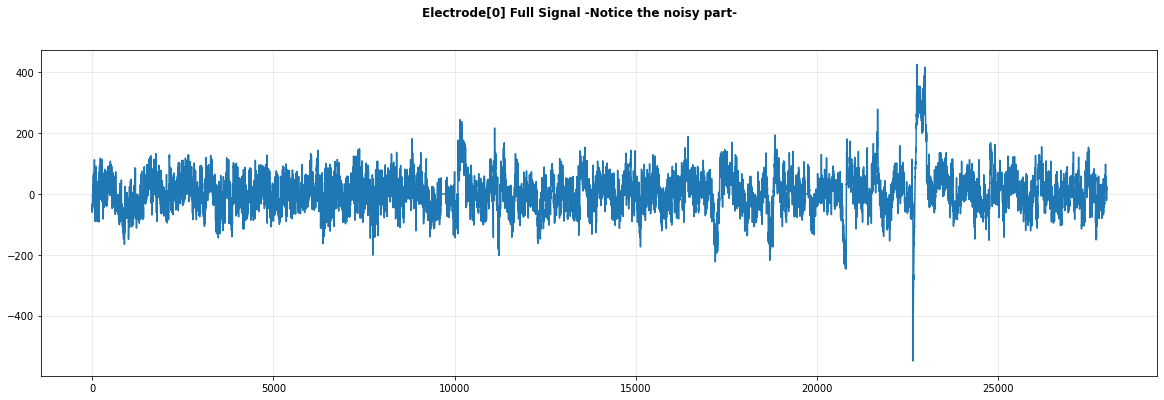

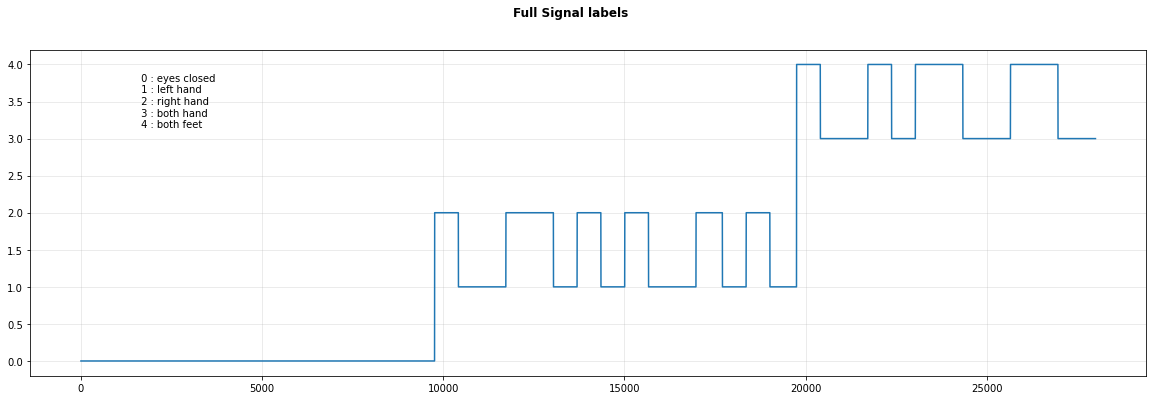

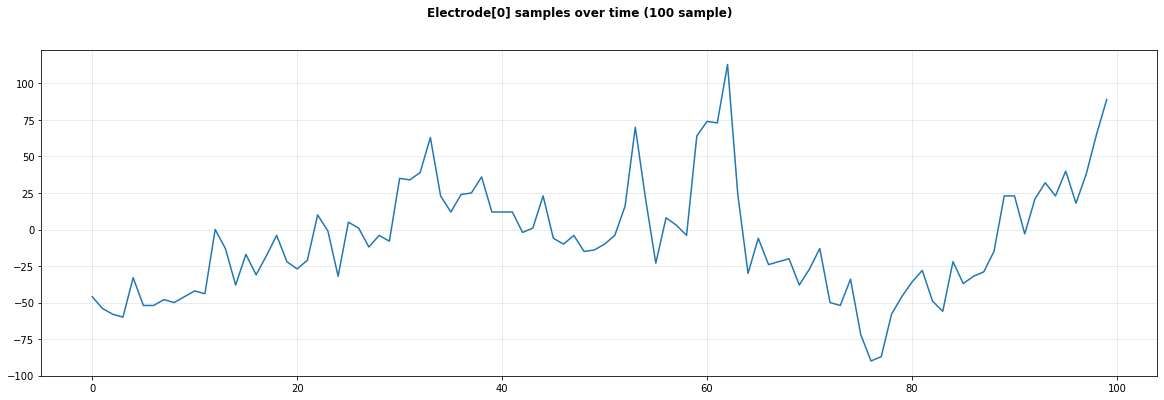

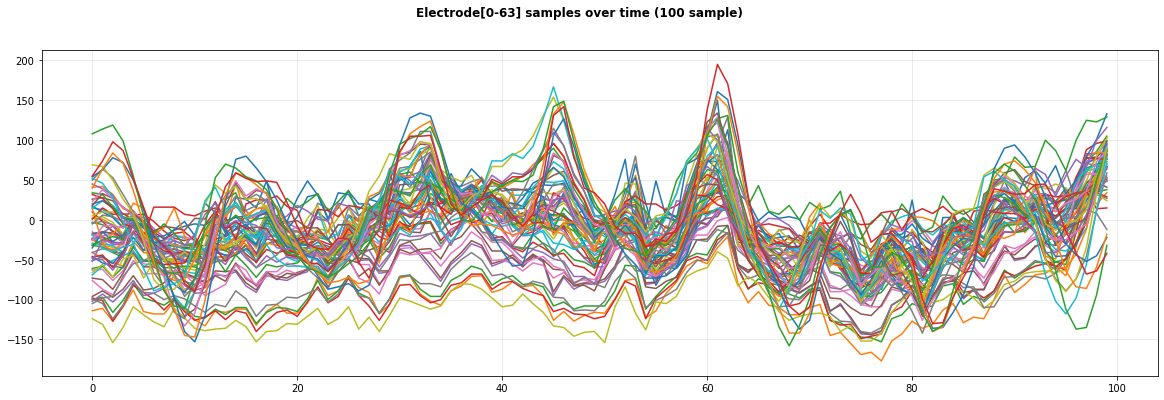

In [29]:

feature_all_orig = np.expand_dims(feature_all_orig, axis=1)
label_orig=all_orig[:,64:65]


print ("Shape feature_all_orig:" ,feature_all_orig.shape)
print ("Shape label:" ,label_orig.shape)

first_time_step_features =feature_all_orig[0]

print ("Shape first_time_step_features:" ,first_time_step_features.shape)

first_time_step_label=label_orig[0]


print ("Value first_time_step_label:" ,first_time_step_label)


all_time_steps_for_first_feature=feature_all_orig[:,:,0]

print ("all_time_steps_for_first_feature :" ,all_time_steps_for_first_feature.shape)

all_time_steps_all_features=feature_all_orig[:,0]


print ("labels for all_time_steps :" ,label_orig.shape)

x=np.linspace(0 , 28000,  28000)



plot_signal(x, all_time_steps_for_first_feature,(20,6) , """Electrode[0] Full Signal -Notice the noisy part- """,0)

figtext_args= [0.2, 0.7," 0 : eyes closed \n 1 : left hand \n 2 : right hand \n 3 : both hand \n 4 : both feet" ]

plot_signal_with_figtext(x, label_orig-1,(20,6) , """Full Signal labels""",0,figtext_args)


plot_signal(x[0:100], all_time_steps_for_first_feature[0:100],(20,6) , """Electrode[0] samples over time (100 sample) """, 0)

plot_signal(x[0:100], all_time_steps_all_features[0:100],(20,6) , """Electrode[0-63] samples over time (100 sample) """, 0)


plt.show()


##Confirm Dataset&Dataloaders compatibility with model

Here I am confirming the compabilitiy between models and loaders and different types of input data

###Confirm for CNN

In [30]:
import scipy.io
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

batch_size= 4


model = CNN()
optimizer = torch.optim.Adam(model.parameters(), lr=3E-4)

dummy_train_dataset = BrainType(images=feature_training, targets=label_training_no_ohe, transforms=None)

dummy_train_loader = torch.utils.data.DataLoader(dummy_train_dataset, batch_size=batch_size, shuffle=True, )


xx, yy=check_shape_and_type_of_loaderdata(dummy_train_loader)

model = CNN()
model(xx,None)
model(xx,yy)


# print("feature_training.dtype ",feature_training.dtype)
# print("label_training_no_ohe.dtype ",label_training_no_ohe.dtype)

# print("sample_target[0].dtype ",sample_target[0].dtype)
# # print("label_training_no_ohe.dtype ",label_training_no_ohe.dtype)

# print("sample_target[0] ",sample_target[0])
# print("shape sample_target  ",sample_target.shape)



________________________________________
For Loader data:
Shape data:  torch.Size([4, 1, 64]) Dtype data:  torch.float32
Shape label:  torch.Size([4])       Dtype label:  torch.int64
________________________________________
 Size Input for Model  : torch.Size([4, 1, 64])
 Size After Conv1 : torch.Size([4, 2, 64])
 Size After pool1: torch.Size([4, 2, 32])
 Size After Conv2: torch.Size([4, 4, 32])
 Size After pool2: torch.Size([4, 4, 16])
 Size After view: torch.Size([4, 64])
 Size After fc2: torch.Size([4, 120])
 Size After Output Layer: torch.Size([4, 5])


(tensor([[  0.6630,  -9.2041,   4.9797, -10.9516,   1.3756],
         [ -4.1233,  -1.6757,   1.8290,  -1.4287,   0.7934],
         [ -1.6306,  -4.9367,   4.8707,  -1.0584,   1.8322],
         [ -0.0856,  -1.6375,  -0.0210,  -3.5100,   2.3952]],
        grad_fn=<AddmmBackward0>), tensor(2.4365, grad_fn=<NllLossBackward0>))

###Confirm for CNN2

In [31]:
import scipy.io
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D


model2 = CNN2()

#  optimizer = optim.Adam(net.parameters(),0.001)
optimizer = torch.optim.Adam(model2.parameters(), lr=3E-4)

feature_training_with_extra_dimension = np.expand_dims(feature_training, axis=1)

dummy_train_dataset = BrainType(images=feature_training_with_extra_dimension, targets=label_training_no_ohe, transforms=None)

dummy_train_loader = torch.utils.data.DataLoader(dummy_train_dataset, batch_size=batch_size, shuffle=True, )


xx, yy=check_shape_and_type_of_loaderdata(dummy_train_loader)


model2(xx,None)
model2(xx,yy)


# print("feature_training.dtype ",feature_training.dtype)
# print("label_training_no_ohe.dtype ",label_training_no_ohe.dtype)

# print("sample_target[0].dtype ",sample_target[0].dtype)
# # print("label_training_no_ohe.dtype ",label_training_no_ohe.dtype)

# print("sample_target[0] ",sample_target[0])
# print("shape sample_target  ",sample_target.shape)




________________________________________
For Loader data:
Shape data:  torch.Size([4, 1, 1, 64]) Dtype data:  torch.float32
Shape label:  torch.Size([4])       Dtype label:  torch.int64
________________________________________
 Size Input for Model  : torch.Size([4, 1, 1, 64])
 Size After Conv1 : torch.Size([4, 2, 1, 64])
 Size After pool1: torch.Size([4, 2, 1, 32])
 Size After Conv2: torch.Size([4, 4, 1, 32])
 Size After pool2: torch.Size([4, 4, 1, 16])
 Size After view: torch.Size([4, 64])
 Size After fc2: torch.Size([4, 120])
 Size After Output Layer: torch.Size([4, 5])


(tensor([[ 0.0799,  0.0766,  0.0638,  0.0270,  0.0576],
         [ 0.0291,  0.2187,  0.2194,  0.0088,  0.1067],
         [-0.1255,  0.1874,  0.3773,  0.1580, -0.0149],
         [ 0.0231,  0.0080,  0.1078,  0.0159,  0.0919]],
        grad_fn=<AddmmBackward0>), tensor(1.5730, grad_fn=<NllLossBackward0>))

###Confirm for CNN2v2

In [32]:



model_CNN2v2 = CNN2v2()
optimizer = torch.optim.Adam(model_CNN2v2.parameters(), lr=3E-4)


dummy_train_dataset = BrainType(images=feature_training_with_extra_dimension, targets=label_training_OHE, transforms=None)
dummy_train_loader_for_CNN2v2 = torch.utils.data.DataLoader(dummy_train_dataset, batch_size=batch_size, shuffle=True, )


xx, yy=check_shape_and_type_of_loaderdata(dummy_train_loader_for_CNN2v2)


model_CNN2v2(xx,None)
model_CNN2v2(xx,yy)




________________________________________
For Loader data:
Shape data:  torch.Size([4, 1, 1, 64]) Dtype data:  torch.float32
Shape label:  torch.Size([4, 5])       Dtype label:  torch.float64
________________________________________
 Size Input for Model  : torch.Size([4, 1, 1, 64])
 Size After Conv1 : torch.Size([4, 20, 1, 64])
 Size After pool1: torch.Size([4, 20, 1, 32])
 x.size()[0]: 4
 Size After view: torch.Size([4, 640])
 Size After fc1: torch.Size([4, 120])
 Size After fc2: torch.Size([4, 5])
  


(tensor([[-0.4661,  0.7313,  0.3526,  0.1943, -0.4749],
         [-0.1553,  0.6535,  0.4132,  0.3532, -0.6532],
         [-0.3942,  0.3225,  0.6773,  0.6733,  0.0997],
         [-0.0148,  0.2006, -0.0343,  0.3466, -0.6035]],
        grad_fn=<AddmmBackward0>),
 tensor(1.8580, dtype=torch.float64, grad_fn=<DivBackward1>))

###Confirm for RNN

In [33]:

input_size=1 
seq_size=64
output_size = 5
hidden_dim = 512
n_layers = 6


model_RNN = RNN(input_size, seq_size,output_size, hidden_dim, n_layers)
optimizer = torch.optim.Adam(model_RNN.parameters(), lr=3E-4)

dummy_train_dataset = BrainType(images=feature_training , targets=label_training_no_ohe , transforms=None)
dummy_train_loader_for_RNN = torch.utils.data.DataLoader(dummy_train_dataset, batch_size=batch_size, shuffle=True, )


xx, yy=check_shape_and_type_of_loaderdata(dummy_train_loader_for_RNN)


model_RNN(xx,None)
model_RNN(xx,yy)




________________________________________
For Loader data:
Shape data:  torch.Size([4, 1, 64]) Dtype data:  torch.float32
Shape label:  torch.Size([4])       Dtype label:  torch.int64
________________________________________
 -------------------Inside RNN forward--------- 
 Size Input for Model  : torch.Size([4, 1, 64])
 Size lstm_out  : torch.Size([4, 1, 512])
 Size h_out  : torch.Size([6, 4, 512])
 Size-new after cont lstm_out  : torch.Size([4, 1, 512])
 Size-new lstm_out  : torch.Size([4, 512])
 Size-new h_out  : torch.Size([24, 512])
 Size x after fc   : torch.Size([4, 5])


(tensor([[ 0.0071, -0.0434,  0.0348,  0.0249,  0.0024],
         [ 0.0069, -0.0444,  0.0328,  0.0229,  0.0022],
         [ 0.0076, -0.0437,  0.0351,  0.0228,  0.0037],
         [ 0.0059, -0.0437,  0.0337,  0.0251,  0.0021]],
        grad_fn=<AddmmBackward0>), tensor(1.6029, grad_fn=<NllLossBackward0>))

###Confirm for RNN2



In [34]:
input_size=1 
seq_size=64
output_size = 5
hidden_size = 512
hidden_size2 = 64
n_layers = 6
n_layers2 = 1


model_RNN2 = RNN2(input_size, seq_size,output_size, hidden_size, hidden_size2,n_layers,n_layers2 )
optimizer = torch.optim.Adam(model_RNN2.parameters(), lr=3E-4)

dummy_train_dataset = BrainType(images=feature_training , targets=label_training_no_ohe , transforms=None)
dummy_train_loader_for_RNN = torch.utils.data.DataLoader(dummy_train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)


xx, yy=check_shape_and_type_of_loaderdata(dummy_train_loader_for_RNN)

model_RNN2(xx,None)
model_RNN2(xx,yy)


________________________________________
For Loader data:
Shape data:  torch.Size([4, 1, 64]) Dtype data:  torch.float32
Shape label:  torch.Size([4])       Dtype label:  torch.int64
________________________________________
 -------------------Inside RNN forward--------- 
 Size Input for Model  : torch.Size([4, 1, 64])
 Size h_0  : torch.Size([6, 4, 512])
 Size c_0  : torch.Size([6, 4, 512])
 Size lstm_out  : torch.Size([4, 1, 512])
 Size lstm_out  : torch.Size([4, 1, 512])
 Size h_02  : torch.Size([1, 4, 64])
 Size c_02  : torch.Size([1, 4, 64])
 Size after  lstm_out2  : torch.Size([4, 1, 64])
 Size after view lstm_out  : torch.Size([4, 64])
 Size after view h_out  : torch.Size([4, 64])
 Size x after fc   : torch.Size([4, 5])


(tensor([[-0.0149, -0.0922, -0.1127, -0.0751,  0.0699],
         [-0.0153, -0.0922, -0.1126, -0.0745,  0.0700],
         [-0.0153, -0.0921, -0.1131, -0.0755,  0.0702],
         [-0.0153, -0.0926, -0.1137, -0.0748,  0.0701]],
        grad_fn=<AddmmBackward0>), tensor(1.5881, grad_fn=<NllLossBackward0>))

#TRAIN FUNCTIONS
For CNN and RNN and AE



```

              **nn.CrossEntropyLoss:**

              Input:
              (N, C) where C = number of classes, or
              (N, C, d_1, d_2, ..., d_K) with K >= 1 in the case of K-dimensional loss.
              Target:
              (N) where each value is in range [0, C-1] or
              (N, d_1, d_2, ..., d_K) with K >= 1 in the case of K-dimensional loss.

              **nn.MSELoss:**

              Input:
              (N,∗) where ∗ means, any number of additional dimensions.
              Target:
              (N,∗), same shape as the input

```



In [35]:


def train_function(model, train_loader, optimizer):

    model.train()
    fin_loss = 0

    
    
    for batch_data, batch_targets in train_loader:


            
            optimizer.zero_grad()
            output,loss = model(batch_data,batch_targets)
           
            loss.requres_grad = True
          
            optimizer.step()
            fin_loss += loss.item()



    return fin_loss / len(train_loader)


def eval_function(model, test_loader, optimizer):

    model.eval()
    final_loss=0
    raw_outputs= []


    for batch_data , batch_targets in test_loader:
        
        batch_outputs, loss = model(batch_data, batch_targets)
        loss.requres_grad= True

        final_loss+=loss.item()

        raw_outputs.append(batch_outputs.detach())

    avr_loss= final_loss/len(test_loader)

    return raw_outputs,avr_loss



def AE_train_function(model, train_loader,optimizer):

    model.train()
    fin_loss = 0
    for batch_data, _ in train_loader:
            optimizer.zero_grad()
            
            output = model(batch_data)

            crit = nn.MSELoss()
            
            loss_AE=crit(output,batch_data)
            loss_AE.backward( retain_graph=True)

            
           
            loss_AE.requres_grad = True
          
            optimizer.step()

            
            fin_loss += loss_AE.item()



    return fin_loss / len(train_loader)


def AE_eval_function(model, loader,optimizer):

    model.eval()
    final_loss=0
    raw_outputs= []

    for batch_data , _ in loader:
        
        batch_outputs = model(batch_data)

        raw_outputs.extend(batch_outputs.detach())


    return raw_outputs


def VAE_train_function( model,train_loader,optimizer):
    model.train()
    train_loss = 0
    for data, _ in train_loader:
        
        optimizer.zero_grad()
        # print("data:", data)
        recon_batch, mu, logvar = model(data)
        # print("recon_batch:", recon_batch)
        # print("mu:", mu)
        # print("logvar:", logvar)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    avg_loss= train_loss / len(train_loader.dataset)
   
    return avg_loss

def VAE_eval_function(model,test_loader,optimizer):
    model.eval()
    test_loss = 0
    reconstructed_data= []
    
    for data, _ in test_loader:
        batch_size=data.size()[0]
        recon_batch, mu, logvar = model(data)
        reconstructed_data.extend(recon_batch.detach())

    return reconstructed_data

# Reconstruction + KL divergence losses summed over all elements and batch
# def loss_function(recon_x, x, mu, logvar):
#     BCE = F.binary_cross_entropy(recon_x, x.view(-1, 184), reduction='sum')

#     # see Appendix B from VAE paper:
#     # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
#     # https://arxiv.org/abs/1312.6114
#     # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
#     KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

#     return BCE + KLD

def loss_function(recon_x, x, mu, logvar):
    # x=torch.sigmoid(x)
    # recon_x=torch.sigmoid(recon_x)
    # BinaryCrossEntropyWithLogits
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 184), reduction='sum')


    # print("recon_x", recon_x.shape)
    # print("x", x.shape)

    crit = nn.MSELoss()
            
    MSE=crit(recon_x,x)
    # print("VVVVVVVVVV: ",MSE)

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD

    


#POSTPROCESSING

In [36]:
import torch
def decode_batch_outputs(batch_outputs):

    # print(" Shape batch_outputs",batch_outputs.shape)
    # Shape batch_outputs torch.Size([50, 5])
    predictions=[]
    bs , _ = batch_outputs.shape
    
    k=torch.softmax(batch_outputs, 1)

   
    for j in range(bs):
        temp=k[j,:]
        # print("tem:", temp)
        prediction= decode_model_output(temp)
        # print("prediction:", prediction)
        predictions.append(prediction)

    return predictions



def decode_model_output(probabilities):
  
    probabilities= probabilities.detach().numpy()
    a=max(probabilities)
    cc=probabilities.tolist().index(a)
    return cc

#MAIN CELL

###CREATE LOADERS

In [37]:



BATCH_SIZE_CNN= 100

feature_training_with_extra_dimension = np.expand_dims(feature_training, axis=1)
feature_testing_with_extra_dimension = np.expand_dims(feature_testing, axis=1)


train_loader_CNN, test_loader_CNN= Create_Loaders(feature_training_with_extra_dimension, 
                                          feature_testing_with_extra_dimension, 
                                          label_training_OHE,
                                          label_testing_OHE, 
                                          BATCH_SIZE_CNN)




BATCH_SIZE_RNN= 100

train_loader_RNN, test_loader_RNN= Create_Loaders(feature_training, 
                                          feature_testing, 
                                          label_training_OHE,
                                          label_testing_OHE, 
                                          BATCH_SIZE_RNN)

xx2, yy2=check_shape_and_type_of_loaderdata(train_loader_CNN)
xx, yy=check_shape_and_type_of_loaderdata(train_loader_RNN)


print(yy[35])
print(yy2[35])

________________________________________
For Loader data:
Shape data:  torch.Size([100, 1, 1, 64]) Dtype data:  torch.float32
Shape label:  torch.Size([100, 5])       Dtype label:  torch.float64
________________________________________
________________________________________
For Loader data:
Shape data:  torch.Size([100, 1, 64]) Dtype data:  torch.float32
Shape label:  torch.Size([100, 5])       Dtype label:  torch.float64
________________________________________
tensor([0., 0., 0., 1., 0.], dtype=torch.float64)
tensor([0., 0., 0., 1., 0.], dtype=torch.float64)


##TRAIN CNN


In [38]:

# check_shape_and_type_of_loaderdata(train_loader_CNN)



# model_CNN2v2 = CNN2v2()
# optimizer = torch.optim.Adam(model_CNN2v2.parameters(), lr=0.0001)

# EPOCH_CNN= 1000


# print(" ")
# print("______________________  CNN2v2 TRAINING ______________________")
# print(" ")
# for epoch in range(EPOCH_CNN):

#     train_loss = train_function(model_CNN2v2, train_loader_CNN, optimizer)
#     all_predictions= []

#     if (epoch + 1) % 5 == 0:


#        outputs, test_loss = eval_function(model_CNN2v2, test_loader_CNN, optimizer)

#        for e in outputs:
#             batch_predictions = decode_batch_outputs(e)
#             all_predictions.extend(batch_predictions)

#        a=accuracy_score(label_testing_no_ohe,  all_predictions)
#        print("Epoch  :",epoch+1 , ", Loss :", train_loss, ", Acc:", a)

# EPOCH = EPOCH_CNN
# PATH = "model_CNN2v2.pt"
# LOSS = train_loss

# torch.save({'epoch': EPOCH,
#             'model_state_dict': model_CNN2v2.state_dict(),
#             'optimizer_state_dict': optimizer.state_dict(),
#             'loss': LOSS, }, PATH)

###LOAD TRAINED CNN MODEL

In [39]:
PATH= "/content/model_CNN_1000E_075_ACC.pt"
model_CNN2v2 = CNN2v2()
optimizer = torch.optim.Adam(model_CNN2v2.parameters(), lr=3E-4)

checkpoint = torch.load(PATH)
model_CNN2v2.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

model_CNN2v2.eval()
# # - or -
# model_CNN2.train()

CNN2v2(
  (conv_1): Conv2d(1, 20, kernel_size=(1, 1), stride=(1, 1))
  (pool_1): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
  (pool_2): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=640, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=5, bias=True)
)

In [40]:
# !tar cvfz allfiles.tar.gz *

##TRAIN RNN

In [41]:

# from sklearn.metrics import accuracy_score

# #HYPERPARAMETERS
# EPOCH_CNN= 1000

# BATCH_SIZE= 100

# # feature_training_with_extra_dimension = np.expand_dims(feature_training, axis=1)
# # feature_testing_with_extra_dimension = np.expand_dims(feature_testing, axis=1)

# train_loader, test_loader= Create_Loaders(feature_training, 
#                                           feature_testing, 
#                                           label_training_OHE,
#                                           label_testing_OHE, 
#                                           BATCH_SIZE)


# check_shape_and_type_of_loaderdata(train_loader)


# input_size=1 
# seq_size=64
# output_size = 5
# hidden_dim = 256
# n_layers = 6


# model_RNN = RNN(input_size, seq_size,output_size, hidden_dim, n_layers)


# optimizer = torch.optim.Adam(model_RNN.parameters(), lr=0.0001)

# print(" ")
# print("______________________  model_RNN TRAINING ______________________")
# print(" ")
# for epoch in range(EPOCH_CNN):

#     train_loss = train_function(model_RNN, train_loader, optimizer)
#     all_predictions= []

#     if (epoch + 1) % 5 == 0:


#        outputs, test_loss = eval_function(model_RNN, test_loader, optimizer)

#        for e in outputs:
#             batch_predictions = decode_batch_outputs(e)
#             all_predictions.extend(batch_predictions)

#        a=accuracy_score(label_testing_no_ohe,  all_predictions)
#        print("Epoch  :",epoch+1 , ", Loss :", train_loss, ", Acc:", a)

# EPOCH = EPOCH_CNN
# PATH = "model.pt"
# LOSS = train_loss

# torch.save({'epoch': EPOCH,
#             'model_state_dict': model_RNN.state_dict(),
#             'optimizer_state_dict': model_RNN.state_dict(),
#             'loss': LOSS, }, PATH)

In [42]:
# EPOCH = 869
# PATH = "model_RNN_400e_ACC_098.pt"
# LOSS = train_loss

# torch.save({'epoch': EPOCH,
#             'model_state_dict': model_RNN.state_dict(),
#             'optimizer_state_dict': optimizer.state_dict(),
#             'loss': LOSS, }, PATH)

###LOAD TRAINED RNN MODEL

In [43]:
PATH= "/content/model_RNN_869e_ACC_098.pt"

input_size=1 
seq_size=64
output_size = 5
hidden_dim = 256
n_layers = 6



model_RNN = RNN(input_size, seq_size,output_size, hidden_dim, n_layers)
optimizer_RNN = torch.optim.Adam(model_RNN.parameters(), lr=0.0001)






checkpoint = torch.load(PATH)
model_RNN.load_state_dict(checkpoint['model_state_dict'])
optimizer_RNN.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

model_RNN.eval()
# # - or -
# model_RNN.train()


RNN(
  (lstm): LSTM(64, 256, num_layers=6, batch_first=True, dropout=0.5)
  (fc): Linear(in_features=256, out_features=5, bias=True)
  (sigmoid): Sigmoid()
)

##TRAIN RNN2

In [44]:

# from sklearn.metrics import accuracy_score

# #HYPERPARAMETERS
# EPOCH_CNN= 1000

# BATCH_SIZE= 100

# # feature_training_with_extra_dimension = np.expand_dims(feature_training, axis=1)
# # feature_testing_with_extra_dimension = np.expand_dims(feature_testing, axis=1)

# train_loader, test_loader= Create_Loaders(feature_training, 
#                                           feature_testing, 
#                                           label_training_OHE,
#                                           label_testing_OHE, 
#                                           BATCH_SIZE)


# check_shape_and_type_of_loaderdata(train_loader)


# input_size=1 
# seq_size=64
# output_size = 5
# hidden_size = 256
# hidden_size2 = 64
# n_layers = 6
# n_layers2 = 1


# model_RNN2 = RNN2(input_size, seq_size,output_size, hidden_size, hidden_size2,n_layers,n_layers2 )


# optimizer = torch.optim.Adam(model_RNN2.parameters(), lr=0.0001)

# print(" ")
# print("______________________  model_RNN2 TRAINING ______________________")
# print(" ")
# for epoch in range(EPOCH_CNN):

#     train_loss = train_function(model_RNN2, train_loader, optimizer)
#     all_predictions= []

#     if (epoch + 1) % 5 == 0:


#        outputs, test_loss = eval_function(model_RNN2, test_loader, optimizer)

#        for e in outputs:
#             batch_predictions = decode_batch_outputs(e)
#             all_predictions.extend(batch_predictions)

#        a=accuracy_score(label_testing_no_ohe,  all_predictions)
#        print("Epoch  :",epoch+1 , ", Loss :", train_loss, ", Acc:", a)

# EPOCH = EPOCH_CNN
# PATH = "RNN2.pt"
# LOSS = train_loss

# torch.save({'epoch': EPOCH,
#             'model_state_dict': model_RNN2.state_dict(),
#             'optimizer_state_dict': model_RNN2.state_dict(),
#             'loss': LOSS, }, PATH)

###LOAD TRAINED RNN2 MODEL

In [45]:
PATH= "/content/RNN2_595e_097_acc.pt"

input_size=1 
seq_size=64
output_size = 5
hidden_size = 256
hidden_size2 = 64
n_layers = 6
n_layers2 = 1


model_RNN2 = RNN2(input_size, seq_size,output_size, hidden_size, hidden_size2,n_layers,n_layers2 )


optimizer_RNN2 = torch.optim.Adam(model_RNN2.parameters(), lr=0.0001)


checkpoint = torch.load(PATH)
model_RNN2.load_state_dict(checkpoint['model_state_dict'])
# optimizer_RNN2.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

model_RNN2.eval()
# # - or -
# model_RNN2.train()

RNN2(
  (lstm): LSTM(64, 256, num_layers=6, batch_first=True, dropout=0.5)
  (lstm2): LSTM(256, 64, batch_first=True)
  (view_for_lstm2): Lin_View()
  (fc): Linear(in_features=64, out_features=5, bias=True)
  (sigmoid): Sigmoid()
)

##EXTRACT FEATURES

###ADD HOOK TO MODELS

In [46]:

print("                       Layer list for CNN HOOK:")
print(" ")
# model__CNN2V2_hooked_layer4= FE(model_CNN2v2,output_layers = [4])
Features_CNN2v2 = FE(model_CNN2v2,output_layers = [4])
printt()
print("                      Layer list for RNN HOOK:")
print(" ")
# model_RNN2_hooked_layer2=FE(model_RNN2,output_layers = [2])
Features_RNN2 = FE(model_RNN2,output_layers = [2])
printt()

                       Layer list for CNN HOOK:
 
model_instance._modules.keys(): odict_keys(['conv_1', 'pool_1', 'pool_2', 'dropout', 'fc1', 'fc2'])
index: 0 , keys: conv_1
index: 1 , keys: pool_1
index: 2 , keys: pool_2
index: 3 , keys: dropout
index: 4 , keys: fc1
------------------------ > Hook is placed output of : fc1
index: 5 , keys: fc2
 
 
 
 
                      Layer list for RNN HOOK:
 
model_instance._modules.keys(): odict_keys(['lstm', 'lstm2', 'view_for_lstm2', 'fc', 'sigmoid'])
index: 0 , keys: lstm
index: 1 , keys: lstm2
index: 2 , keys: view_for_lstm2
------------------------ > Hook is placed output of : view_for_lstm2
index: 3 , keys: fc
index: 4 , keys: sigmoid
 
 
 
 


###CONFIRM HOOKS

In [47]:


xx, yy=check_shape_and_type_of_loaderdata(dummy_train_loader_for_RNN)
xx2, yy2=check_shape_and_type_of_loaderdata(dummy_train_loader_for_CNN2v2)



out, layerout = Features_CNN2v2(xx2)
# print("CNN layerout.key:", layerout.keys())
print("CNN extracted feature shape:", list(layerout.values())[0].shape)



out, layerout = Features_RNN2(xx)
# print(" RNN layerout.key:", layerout.keys())
A=list(layerout.values())
print("RNN extracted feature shape:", list(layerout.values())[0].shape)

________________________________________
For Loader data:
Shape data:  torch.Size([4, 1, 64]) Dtype data:  torch.float32
Shape label:  torch.Size([4])       Dtype label:  torch.int64
________________________________________
________________________________________
For Loader data:
Shape data:  torch.Size([4, 1, 1, 64]) Dtype data:  torch.float32
Shape label:  torch.Size([4, 5])       Dtype label:  torch.float64
________________________________________
 Size Input for Model  : torch.Size([4, 1, 1, 64])
 Size After Conv1 : torch.Size([4, 20, 1, 64])
 Size After pool1: torch.Size([4, 20, 1, 32])
 x.size()[0]: 4
 Size After view: torch.Size([4, 640])
 Size After fc1: torch.Size([4, 120])
 Size After fc2: torch.Size([4, 5])
  
CNN extracted feature shape: torch.Size([4, 120])
RNN extracted feature shape: torch.Size([4, 64])


###EXTRACT FEATURES

In [48]:


Features_TRAINLOADER_from_RNN2_hook , lbls_RNN ,  Features_TESTLOADER_from_RNN2_hook, lbls_test_RNN  =extract_features(Features_RNN2 ,
                                                               "view_for_lstm2", 
                                                               train_loader_RNN,
                                                               test_loader_RNN)

Features_TRAINLOADER_from_CNN_hook , lbls_CNN ,  Features_TESTLOADER_from_CNN_hook, lbls_test_CNN  =extract_features(Features_CNN2v2 ,
                                                               "fc1", 
                                                               train_loader_CNN,
                                                               test_loader_CNN)


xx, yy=check_shape_and_type_of_loaderdata(train_loader_CNN)
xx2, yy2=check_shape_and_type_of_loaderdata(train_loader_RNN)



print(lbls_test_RNN[2])
print(lbls_test_CNN[2])

________________________________________
For Loader data:
Shape data:  torch.Size([100, 1, 1, 64]) Dtype data:  torch.float32
Shape label:  torch.Size([100, 5])       Dtype label:  torch.float64
________________________________________
________________________________________
For Loader data:
Shape data:  torch.Size([100, 1, 64]) Dtype data:  torch.float32
Shape label:  torch.Size([100, 5])       Dtype label:  torch.float64
________________________________________
tensor([0., 1., 0., 0., 0.], dtype=torch.float64)
tensor([0., 1., 0., 0., 0.], dtype=torch.float64)


###MERGE FEATURES

In [49]:
xray(Features_TRAINLOADER_from_RNN2_hook)
xray(Features_TRAINLOADER_from_CNN_hook)

Train_Features_merged =torch.cat((Features_TRAINLOADER_from_RNN2_hook, Features_TRAINLOADER_from_CNN_hook), 1)
Test_Features_merged =torch.cat((Features_TESTLOADER_from_RNN2_hook, Features_TESTLOADER_from_CNN_hook), 1)

# y = x.clone().detach() #b

Train_Features_merged = Train_Features_merged.clone().detach()
Test_Features_merged = Test_Features_merged.clone().detach()


# Train_Features_merged.detach() 
# Test_Features_merged.detach() 

xray(Train_Features_merged)

xray(Test_Features_merged)


Tensor,  Shape: torch.Size([21000, 64])
Tensor,  Shape: torch.Size([21000, 120])
Tensor,  Shape: torch.Size([21000, 184])
Tensor,  Shape: torch.Size([7000, 184])


##TRAIN AE

The loss does not seem to reflect the reconstruction. 

###Prepared Loaders

In [50]:
batch_size=100


Train_Features_merged_as_list =convert_tensor_to_list_of_tensors(Train_Features_merged)
Test_Features_merged_as_list =convert_tensor_to_list_of_tensors(Test_Features_merged)


lbls_test_RNN_as_list =convert_tensor_to_list_of_tensors(lbls_test_RNN)
lbls_RNN_as_list =convert_tensor_to_list_of_tensors(lbls_RNN)


train_dataset_AE = BasicDataset(images=Train_Features_merged_as_list, targets=lbls_RNN_as_list)
train_loader_AE = torch.utils.data.DataLoader(train_dataset_AE, batch_size=batch_size, shuffle=True, )

test_dataset_AE = BasicDataset(images=Test_Features_merged_as_list, targets=lbls_test_RNN_as_list)
test_loader_AE = torch.utils.data.DataLoader(test_dataset_AE, batch_size=batch_size, shuffle=False, )

###Create Model Instances

You can choose bunch of 

In [51]:
model_list=[]
optimizer_list=[]
learning_rate= 1e-3



# model_DUMMY = DUMMY()
# optimizer_DUMMY = torch.optim.Adam(model_DUMMY.parameters(), lr=1e-3)
# model_list.append(model_DUMMY)
# optimizer_list.append(optimizer_DUMMY)

# model_VAE = VAE()
# optimizer_VAE = torch.optim.Adam(model_VAE.parameters(), lr=1e-2,  weight_decay=1e-5)
# model_list.append(model_VAE)
# optimizer_list.append(optimizer_VAE)


AutoEncoder = AE(input_shape=184)
optimizer_AE = torch.optim.Adam(AutoEncoder.parameters(), lr=learning_rate,  weight_decay=1e-5)
model_list.append(AutoEncoder)
optimizer_list.append(optimizer_AE)

# AutoEncoder2 = AE2(input_shape=184)
# optimizer_AE2 = torch.optim.Adam(AutoEncoder2.parameters(), lr=learning_rate,  weight_decay=1e-5)
# model_list.append(AutoEncoder2)
# optimizer_list.append(optimizer_AE2)

# AutoEncoder3 = AE3(input_shape=184)
# optimizer_AE3 = torch.optim.Adam(AutoEncoder3.parameters(), lr=learning_rate,  weight_decay=1e-5)
# model_list.append(AutoEncoder3)
# optimizer_list.append(optimizer_AE3)

# AutoEncoder4 = AE4(input_shape=184)
# optimizer_AE4 = torch.optim.Adam(AutoEncoder4.parameters(), lr=learning_rate,  weight_decay=1e-5)
# model_list.append(AutoEncoder4)
# optimizer_list.append(optimizer_AE4)

# AutoEncoder5 = AE5(input_shape=184)
# optimizer_AE5 = torch.optim.Adam(AutoEncoder5.parameters(), lr=learning_rate,  weight_decay=1e-5)
# model_list.append(AutoEncoder5)
# optimizer_list.append(optimizer_AE5)

# AutoEncoder6 = AE6(input_shape=184)
# optimizer_AE6 = torch.optim.Adam(AutoEncoder6.parameters(), lr=learning_rate,  weight_decay=1e-5)
# model_list.append(AutoEncoder6)
# optimizer_list.append(optimizer_AE6)



model_list

[AE(
   (encoder_hidden_layer): Linear(in_features=184, out_features=100, bias=True)
   (encoder_output_layer): Linear(in_features=100, out_features=75, bias=True)
   (decoder_hidden_layer): Linear(in_features=75, out_features=100, bias=True)
   (decoder_output_layer): Linear(in_features=100, out_features=184, bias=True)
   (leaky): LeakyReLU(negative_slope=0.01)
 )]

###Train Loops for AE

Use VAE_train_function for VAE
 
Use AE_train_function  for AE 

In [52]:
EPOCH= 20
for i in range(len(model_list)):
    
    AE_model=model_list[i]
    print(AE_model)
    optimizer_model=optimizer_list[i]

    for epoch in range(EPOCH):

        AE_train_loss= AE_train_function(AE_model,  train_loader_AE,  optimizer_model)
        print("AE",str(i+1)," :", "epoch: ",epoch ,  "LOSS:", AE_train_loss)
    print(" ")


EPOCH = 500
PATH = "model_AE.pt"
LOSS = AE_train_loss

torch.save({'epoch': EPOCH,
            'model_state_dict': AutoEncoder.state_dict(),
            'optimizer_state_dict': optimizer_AE.state_dict(),
            'loss': LOSS, }, PATH)


AE(
  (encoder_hidden_layer): Linear(in_features=184, out_features=100, bias=True)
  (encoder_output_layer): Linear(in_features=100, out_features=75, bias=True)
  (decoder_hidden_layer): Linear(in_features=75, out_features=100, bias=True)
  (decoder_output_layer): Linear(in_features=100, out_features=184, bias=True)
  (leaky): LeakyReLU(negative_slope=0.01)
)
AE 1  : epoch:  0 LOSS: 2461.0140985398066
AE 1  : epoch:  1 LOSS: 2073.744517299107
AE 1  : epoch:  2 LOSS: 1810.6571585518973
AE 1  : epoch:  3 LOSS: 1670.9614519391741
AE 1  : epoch:  4 LOSS: 1545.0046927315848
AE 1  : epoch:  5 LOSS: 1438.6274716331845
AE 1  : epoch:  6 LOSS: 1360.2568943568638
AE 1  : epoch:  7 LOSS: 1294.2428466796875
AE 1  : epoch:  8 LOSS: 1235.863271658761
AE 1  : epoch:  9 LOSS: 1185.2517421177456
AE 1  : epoch:  10 LOSS: 1143.2472042992001
AE 1  : epoch:  11 LOSS: 1109.4384251185827
AE 1  : epoch:  12 LOSS: 1082.852714029948
AE 1  : epoch:  13 LOSS: 1060.420624360584
AE 1  : epoch:  14 LOSS: 1041.110588

### LOAD TRAINED AE

In [53]:

# PATH= "/content/model_AE.pt"
# AutoEncoder = AE(input_shape=184)

# learning_rate= 1e-4
# optimizer_AE = torch.optim.Adam(AutoEncoder.parameters(), lr=learning_rate,  weight_decay=1e-5)

# checkpoint = torch.load(PATH)
# AutoEncoder.load_state_dict(checkpoint['model_state_dict'])
# optimizer_AE.load_state_dict(checkpoint['optimizer_state_dict'])
# epoch = checkpoint['epoch']
# loss = checkpoint['loss']

# AutoEncoder.train()
# # - or -
# model_CNN2.train()


In [54]:
# EPOCH = 2000
# PATH = "model_AE2000.pt"
# LOSS = AE_train_loss

# torch.save({'epoch': EPOCH,
#             'model_state_dict': AutoEncoder.state_dict(),
#             'optimizer_state_dict': optimizer_AE.state_dict(),
#             'loss': LOSS, }, PATH)

In [55]:
model_list


[AE(
   (encoder_hidden_layer): Linear(in_features=184, out_features=100, bias=True)
   (encoder_output_layer): Linear(in_features=100, out_features=75, bias=True)
   (decoder_hidden_layer): Linear(in_features=75, out_features=100, bias=True)
   (decoder_output_layer): Linear(in_features=100, out_features=184, bias=True)
   (leaky): LeakyReLU(negative_slope=0.01)
 )]

##PASS THE DATA THROUGH AE

In [56]:
# AE_hooked_1 = FE_unsupervised(AutoEncoder,output_layers = [1])
# AE_hooked_2 = FE_unsupervised(AutoEncoder2,output_layers = [1])
# AE_hooked_3 = FE_unsupervised(AutoEncoder3,output_layers = [0])
# AE_hooked_4 = FE_unsupervised(AutoEncoder4,output_layers = [2])
# AE_hooked_5 = FE_unsupervised(AutoEncoder5,output_layers = [1])
# AE_hooked_6 = FE_unsupervised(AutoEncoder6,output_layers = [1])


# AE1_F , AE1_FT=extract_features2(AE_hooked_1 , "encoder_output_layer", train_loader_AE, test_loader_AE)
# AE2_F , AE2_FT=extract_features2(AE_hooked_2 , "encoder_output_layer", train_loader_AE, test_loader_AE)
# AE3_F , AE3_FT=extract_features2(AE_hooked_3 , "encoder_hidden_layer", train_loader_AE, test_loader_AE)
# AE4_F , AE4_FT=extract_features2(AE_hooked_4 , "encoder_output_layer", train_loader_AE, test_loader_AE)

# list_of_hooked_traindata_outputs=[]
# list_of_hooked_testdata_outputs=[]

# list_of_hooked_traindata_outputs.append(AE1_F)
# list_of_hooked_traindata_outputs.append(AE2_F)
# list_of_hooked_traindata_outputs.append(AE3_F)
# list_of_hooked_traindata_outputs.append(AE4_F)

# list_of_hooked_testdata_outputs.append(AE1_FT)
# list_of_hooked_testdata_outputs.append(AE2_FT)
# list_of_hooked_testdata_outputs.append(AE3_FT)
# list_of_hooked_testdata_outputs.append(AE4_FT)

list_of_reconstructed_traindata_outputs=[]
list_of_reconstructed_testdata_outputs=[]

for i in range(len(model_list)):
    AE_Model=         model_list[i]
    optimizer_model=  optimizer_list[i]
    Reconstructed_Train_Data=[]
    Reconstructed_Test_Data=[]

    Reconstructed_Train_Data= AE_eval_function(AE_Model,  train_loader_AE,  optimizer_model)
    Reconstructed_Test_Data= AE_eval_function(AE_Model,  test_loader_AE,  optimizer_model)

    xray(Reconstructed_Train_Data)
    # xray(Reconstructed_Test_Data)
    # xray(label_training_no_ohe)
    # xray(label_testing_no_ohe)

    # printt()

    Reconstructed_Train_Data = torch.stack(Reconstructed_Train_Data)

    Reconstructed_Test_Data = torch.stack(Reconstructed_Test_Data)

    # xray(Reconstructed_Train_Data)
    # xray(Reconstructed_Test_Data)

    list_of_reconstructed_traindata_outputs.append(Reconstructed_Train_Data)
    list_of_reconstructed_testdata_outputs.append(Reconstructed_Test_Data)

    xray(list_of_reconstructed_traindata_outputs)


List of Tensors,  Len: 21000 , e[0] shape: torch.Size([184])
List of Tensors,  Len: 1 , e[0] shape: torch.Size([21000, 184])


In [57]:
# list_of_reconstructed_traindata_outputs=[]
# list_of_reconstructed_testdata_outputs=[]

# for i in range(len(model_list)):
#     AE_Model=         model_list[i]
#     optimizer_model=  optimizer_list[i]
#     Reconstructed_Train_Data=[]
#     Reconstructed_Test_Data=[]

#     Reconstructed_Train_Data= AE_eval_function(AE_Model,  train_loader_AE,  optimizer_model)
#     Reconstructed_Test_Data= AE_eval_function(AE_Model,  test_loader_AE,  optimizer_model)

#     xray(Reconstructed_Train_Data)
#     # xray(Reconstructed_Test_Data)
#     # xray(label_training_no_ohe)
#     # xray(label_testing_no_ohe)

#     # printt()

#     Reconstructed_Train_Data = torch.stack(Reconstructed_Train_Data)

#     Reconstructed_Test_Data = torch.stack(Reconstructed_Test_Data)

#     # xray(Reconstructed_Train_Data)
#     # xray(Reconstructed_Test_Data)

#     list_of_reconstructed_traindata_outputs.append(Reconstructed_Train_Data)
#     list_of_reconstructed_testdata_outputs.append(Reconstructed_Test_Data)




In [58]:
# PATH= "/content/model_AE2000.pt"
# AutoEncoder = AE(input_shape=184)

# learning_rate= 1e-4
# optimizer_AE = torch.optim.Adam(AutoEncoder.parameters(), lr=learning_rate,  weight_decay=1e-5)

# checkpoint = torch.load(PATH)
# AutoEncoder.load_state_dict(checkpoint['model_state_dict'])
# optimizer_AE.load_state_dict(checkpoint['optimizer_state_dict'])
# epoch = checkpoint['epoch']
# loss = checkpoint['loss']

# AutoEncoder.train()



##XGBOOST CLASSIFICATION

In [59]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score



In [60]:
for i in range(len(model_list)):
  Reconstructed_Train_Data= list_of_reconstructed_traindata_outputs[i]
  Reconstructed_Test_Data= list_of_reconstructed_testdata_outputs[i]
  XGB = XGBClassifier()
  XGB.fit(Reconstructed_Train_Data, label_training_no_ohe)
  y_pred = XGB.predict(Reconstructed_Test_Data)

  predictions = y_pred.astype(int)
  accuracy = accuracy_score(label_testing_no_ohe, predictions)
  print(accuracy)

0.3432857142857143


###XBG (AE HOOKS Reconstructed DATA)

In [62]:
# # list_of_hooked_traindata_outputs=[]
# # list_of_hooked_testdata_outputs=[]

# for i in range(len(list_of_hooked_traindata_outputs)):
#   hooked_Train_Data= list_of_hooked_traindata_outputs[i]
#   hooked_Test_Data= list_of_hooked_testdata_outputs[i]
#   XGB = XGBClassifier()
#   XGB.fit(hooked_Train_Data, label_training_no_ohe)
#   y_pred = XGB.predict(hooked_Test_Data)

#   predictions = y_pred.astype(int)
#   accuracy = accuracy_score(label_testing_no_ohe, predictions)
#   print(accuracy)


###XBG (AE Reconstructed DATA)

In [63]:
# XGB = XGBClassifier()
# XGB.fit(Reconstructed_Train_Data, label_training_no_ohe)
# y_pred = XGB.predict(Reconstructed_Test_Data)

# predictions = y_pred.astype(int)
# accuracy = accuracy_score(label_testing_no_ohe, predictions)
# print(accuracy)

###XBG (CNN+RNN FEATURES COMBINED DATA)

In [64]:
xray(Train_Features_merged)
xray(Test_Features_merged)

XGB2 = XGBClassifier()
XGB2.fit(Train_Features_merged, label_training_no_ohe)
y_pred2 = XGB2.predict(Test_Features_merged)

predictions2 = y_pred2.astype(int)
accuracy2 = accuracy_score(label_testing_no_ohe, predictions2)
print("Accuracy of CNN+RNN features classified with XGBOOST is : ",accuracy2)



Tensor,  Shape: torch.Size([21000, 184])
Tensor,  Shape: torch.Size([7000, 184])
Accuracy of CNN+RNN features classified with XGBOOST is :  0.9957142857142857
